**Ficheux et al, arXiv:2011.02634**

In this notebook we want to capture the basic effect behind the two-qubit gate for fluxonia described in the paper by Ficheux et al(2020) "Fast logic with slow qubits:microwave-activated controlled-Z gate on low-frequency fuxoniums"

In [1]:
import numpy as np
import sys
import time
import datetime
import qutip as qtp 
import cmath
import matplotlib.pyplot as plt
from scipy import constants
from scipy.optimize import minimize
import pysqkit
from pysqkit.util.linalg import get_mat_elem, tensor_prod
from pysqkit.util.phys import thermalenergy_to_temperature, temperature_to_thermalenergy
from pysqkit.solvers import solvkit
from typing import List
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'

from mpl_toolkits.axes_grid1 import make_axes_locatable

from itertools import product, combinations
from IPython.display import display, Latex

%matplotlib notebook
plt.rcParams['figure.figsize'] = (8, 5)

from IPython.display import display, HTML, Image

display(HTML(data="""

<style>
    div#notebook-container    { width: 90%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

%reload_ext jupyternotify

# %notify

<IPython.core.display.Javascript object>

The gate is based on the following driven Hamiltonian of two-capacitively coupled fluxonium qubits

$$\hat{H} = \hat{H}^{(0)}_A + \hat{H}^{(0)}_B + \hat{V} + \hat{H}_{drive}$$

$$\hat{H}^{(0)}_A = 4 E_{C,A} \cdot \hat{n}^2_A + \frac{1}{2}E_{L,A}\cdot\hat{\varphi}^2_A - E_{J,A}\cos\left(\hat{\varphi}_A - \phi_{ext,A}\right)$$

$$\hat{H}^{(0)}_B = 4 E_{C,B} \cdot \hat{n}^2_B + \frac{1}{2}E_{L,B}\cdot\hat{\varphi}^2_B - E_{J,B}\cos\left(\hat{\varphi}_B - \phi_{ext,B}\right)$$

$$\hat{V} = J_C \cdot \hat{n}_A \cdot \hat{n}_B$$

$$\frac{\hat{H}_{drive}}{h} = \left( \epsilon_A \hat{n}_A + \epsilon_B \hat{n}_B \right) \cos(2\pi f_d t)$$

Aim Energy spectrum :
![](energy_levels.jpg)

# Single fluxonia
We take parameters as in Table 1 of the paper

In [ ]:
# Values in GHz (divided by h)
#Fluxonium A
ec_a = .973
el_a = .457
ej_a = 5.899 
flux_a = 1/2#pi in the cos

# Fluxonium B 
ec_b = 1.027
el_b = 0.684
ej_b = 5.768
flux_b = 1/2

n_fock = 100

Let us first reproduce the other parameters in Table 1

In [ ]:
levels = 4
flx_a = pysqkit.qubits.Fluxonium('A', ec_a, el_a, ej_a, flux_a, dim_hilbert=n_fock)
flx_b = pysqkit.qubits.Fluxonium('B', ec_b, el_b, ej_b, flux_b, dim_hilbert=n_fock)
flx_a.diagonalize_basis(levels)
flx_b.diagonalize_basis(levels)

In [ ]:
energies_a, eig_states_a = flx_a.eig_states(levels)
energies_b, eig_states_b = flx_b.eig_states(levels)
for k in range(0, 3):
    print('------')
    print('f_' + str(k) + str(k + 1) + '^A = ' + str(energies_a[k + 1] - energies_a[k]) + ' GHz' )
    print('f_' + str(k) + str(k + 1) + '^B = ' + str(energies_b[k + 1] - energies_b[k]) + ' GHz' )
print('------')

In [ ]:
#plot les nvx d'énergie des a et b ide by side

opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}
text_lab = ["$| " + str(k) + " \\rangle $" for k in range(levels)]

def plot_energies_single(energies, text_lab, opt, name, ax):
    for k in range(0, levels):
        ax.plot([0,1], [energies[k]]*2, color='blue')
        ax.text(-0.1, energies[k], text_lab[k], fontsize=opt['fs_text'], color='blue')

    ax.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
    ax.set_title("$\mathrm{Energy \ levels \ of \ single \ qubit \ }$" + name)
    ax.xaxis.set_visible(False)
    ax.set_xlim(-.1, 1)
    
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_energies_single(energies_a, text_lab, opt, "flx_a",  ax[0])
plot_energies_single(energies_b, text_lab, opt, "flx_b",  ax[1])


Thus, we correctly recover the frequencies Table 1 in the paper. Notice that the eigenenergies are also divided by $h$ and so are intended as frequencies and not as angular velocities;

In [ ]:
for k in range(0, 2):
    print('------')
    print('|n_' + str(k) + str(k + 1) + '^A| = ' + \
          str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[k], eig_states_a[k + 1]))))
    print('|n_' + str(k) + str(k + 1) + '^B| = ' + \
          str(np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[k], eig_states_b[k + 1]))))
print('------')
print('|n_' + str(0) + str(3) + '^A| = '  + \
      str(np.abs(get_mat_elem(flx_a.charge_op(), eig_states_a[0], eig_states_a[3]))))
print('|n_' + str(0) + str(3) + '^B| = '  + \
      str(np.abs(get_mat_elem(flx_b.charge_op(), eig_states_b[0], eig_states_b[3]))))

We see that $n^{\alpha}_{0-1} \ll n^{\alpha}_{1-2}$ as predicted by Ficheux

In [ ]:
def plot_charge_op(flx, name, ax, vmin, vmax):
    lv = range(levels)
    level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in lv]
    mat_elements = flx.mat_elements(operator='charge_op', levels=lv, as_xarray=True)

    
    im = ax.imshow(np.abs(mat_elements), cmap='viridis', vmin = vmin, vmax = vmax)

    for in_level, out_level in product(lv, repeat=2):
        amplitude = abs(mat_elements.sel(in_level=in_level, out_level=out_level))
        ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")

    ax.set_xticks(lv)
    ax.set_yticks(lv)
    ax.set_xticklabels(level_labels, fontsize = 14)
    ax.set_yticklabels(level_labels, fontsize = 14)

#     cbar = plt.colorbar()
#     cbar.ax.set_ylabel(r"Amplitude $\hat{n}^{F}_{i \rightarrow f}$", rotation=-90, va="bottom")

    ax.set_title(name +  ' matrix elements')

    return im

vmin = min(np.min(np.abs(flx_a.mat_elements(operator='charge_op', levels=range(4)))),
           np.min(np.abs(flx_b.mat_elements(operator='charge_op', levels=range(4)))))

vmax = max(np.max(np.abs(flx_a.mat_elements(operator='charge_op', levels=range(4)))),
           np.max(np.abs(flx_b.mat_elements(operator='charge_op', levels=range(4)))))

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ima = plot_charge_op(flx_a, "Flx_A", ax[0], vmin, vmax)
imb = plot_charge_op(flx_b, "Flx_B", ax[1], vmin, vmax)

fig.colorbar(ima, ax=ax.ravel().tolist(), orientation = 'horizontal')

In [ ]:
energies_in_lexico = np.zeros(levels**2, dtype=float)
count = 0
for k in range(0, levels):
    for m in range(0, levels):
        energies_in_lexico[count] = energies_b[m] + energies_a[k]
        count += 1
ascending_to_lexico = np.argsort(energies_in_lexico)

label_converter = ascending_to_lexico
label_converter

If $ \textit{ascending_to_lexico}[i] = j$ Then  $$i^{th}\mathrm{\ in \ ascending \ energies \ order \ is \ } j^{th} \mathrm{\ in \ lexicographic \ order}$$

In [ ]:
# This function allows to return the energy of the "adiabatically continued" coupled levels
def label_to_energies(
    k: int, 
    m: int,
    levels: int,
    energies: np.ndarray,  #in ascending order
    label_converter: np.ndarray 
) -> float:
    label = k*levels + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return energies[index]

def label_to_states(
    k: int, 
    m: int,
    levels: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray 
) -> float:
    label = k*levels + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return eig_states[index] 

In [ ]:
def energy_ascending_order_to_label(
    k : int,
    levels: int,
    label_converter : np.ndarray):
    
    lexico_rank = label_converter[k]
    i = lexico_rank//levels
    j = lexico_rank%levels
    
    return i, j
    

# Coupled fluxonia

As a preliminary study, I want to plot the energy levels of the coupled system as a function of the coupling strength $J_C$. I take coupling strengths similar to those taken in the paper (see Fig. 2).

In [ ]:
levels_plot = 8
labels_to_plot = [energy_ascending_order_to_label(k, levels, label_converter) for  k in range(levels_plot)]

# interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,3], [1,3], [0,4]]
# labels_to_plot = interest_levels

print("We'll plot the following levels :  ")
if 'levels_plot' in locals():
    print("(the " + str(levels_plot)+" first in term of energy)")
for tpl in labels_to_plot:
    print(tpl)

## Role of J_c

In [ ]:
n_points = 20

jc_list = np.linspace(0, 0.4, n_points)
en_mat = np.zeros([levels_plot, n_points], dtype=float)
for k in range(0, n_points):
    coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc_list[k])
    en_mat[:, k] = coupled_flx.eig_energies(levels_plot)

In [ ]:
plot_setup = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

def plot_energies_jc(
    en_mat: np.ndarray, 
    jc_list:np.ndarray, 
    opt:dict
) -> None:
    n_lev = en_mat.shape[0]
    fig, ax = plt.subplots(figsize=(7, 7))
    for k, m in labels_to_plot:
        plt.plot(jc_list, [label_to_energies(k, m, levels, en_mat[:, ii], label_converter) for ii in range(len(jc_list))], 
             linewidth=opt['lw'], color='black')
        plt.text(-0.08, label_to_energies(k, m, levels, en_mat[:, 0], label_converter), 
                 "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='black')
        
    ax.axes.set_xlabel("$J_C \, \mathrm{[GHz]}$", fontsize=opt['fs'])
    ax.axes.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])

    ax.tick_params(axis='both', labelsize=opt['ls'])
    plt.show()
    
plot_energies_jc(en_mat, jc_list, plot_setup) 

## Coupling

In [ ]:
jc = 0.224 #GHz (divided by h)

coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_flx.eig_states() 

coupled_flx_bare = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
energies_bare, eigstates_bare = coupled_flx_bare.eig_states() 


for k in range(len(labels_to_plot)):
    i, j = labels_to_plot[k]
    print(str(k)+"th energy level |" + str((i, j)) + 
                  "> :  Bare : " + str(np.round(label_to_energies(i, j, levels, energies_bare, label_converter), 4)) + 
                  "[GHz] || Interacting : " + str(np.round(label_to_energies(i, j, levels, energies_sys, label_converter), 6)) + "[GHz]")

In [ ]:
# def plot_charge_op(opé, name, xmax, ymax):
#     lvx = range(xmax)
#     lvy = range(ymax)
#     level_labels = ['$ |' + str(  np.argmax(np.abs(level))//levels  ) + \
#                                 str(  np.argmax(np.abs(level)) %levels  ) + '\\rangle $' for level in eigstates_sys]
#     mat_elements = np.zeros((xmax, ymax))
    
    
#     plt.figure(figsize = (7, 7))
#     for a in range(xmax):
#         for b in range(ymax):
#             in_level = np.conj(eigstates_sys[a].T)
#             out_level = eigstates_sys[b]
#             mat_elements[a, b] = np.abs(in_level.dot(opé).dot(out_level))
# #             plt.text(a, b, '{:.2f}'.format(float(mat_elements[a, b])), ha="center", va="center", color="white")


#     plt.imshow(np.abs(mat_elements), cmap='viridis')            

#     plt.xticks(ticks = lvx, labels = level_labels[:xmax], fontsize = 14)
#     plt.yticks(ticks = lvy, labels = level_labels[:ymax], fontsize = 14)

#     plt.title(name +  ' matrix elements')
#     plt.colorbar()
    
#     return mat_elements

# n_a = tensor_prod([flx_a.charge_op(), np.identity(levels)])
# n_b = tensor_prod([np.identity(levels), flx_b.charge_op()])
# ope = n_a*n_b

# _ = plot_charge_op(ope, "$\hat{n}_A \hat{n}_B$",4, 4)

## Energies and eigenvalues of H

In [ ]:
#Compare levels bare-int

opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

plt.figure(figsize=(7, 7))
for k,m in labels_to_plot:
    plt.plot([0,.99], [label_to_energies(k, m, levels, energies_bare, label_converter)]*2, 
             color='blue', linestyle = ':', label = "bare")
    plt.text(-0.08, label_to_energies(k, m, levels, energies_bare, label_converter), 
             "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='blue')

    plt.plot([1.01, 2], [label_to_energies(k, m, levels, energies_bare, label_converter)]*2, 
             color='black', label = "coupled")
    plt.text(+2.03,label_to_energies(k, m, levels, energies_bare, label_converter),
             "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='black')
    
    if (k, m)==(0, 0):
        plt.legend()
    
plt.ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
plt.tick_params(axis='both', labelsize=opt['ls'])

frame1 = plt.gca()
frame1.axes.xaxis.set_visible(False)



# Drive

In [ ]:
eig_states_by_label = []

for i_a in range(levels):
    eig_states_by_label.append([])
    for i_b in range(levels):
        eig_states_by_label[i_a].append(qtp.Qobj(inpt=  label_to_states(i_a, i_b, levels, eigstates_sys, label_converter), 
                   dims=[[levels, levels], [1, 1]], shape=[levels*levels, 1]))

In [ ]:
n_a = qtp.tensor(flx_a.charge_op(as_qobj = True), qtp.qeye(flx_b.charge_op(as_qobj = True).dims[0]))
n_b = qtp.tensor(qtp.qeye(flx_a.charge_op(as_qobj = True).dims[0]), flx_b.charge_op(as_qobj = True))
n_charge = [n_a, n_b]

In [ ]:
big_delta = ( label_to_energies(2, 1, levels, energies_sys, label_converter)   - \
              label_to_energies(1, 1, levels, energies_sys, label_converter) ) - \
            ( label_to_energies(2, 0, levels, energies_sys, label_converter)   - \
              label_to_energies(1, 0, levels, energies_sys, label_converter) )

print("Big Delta is :", big_delta*1000, "MHz")

According to the paper we have :

$$\Omega_{11-21}  = \left| \epsilon_A \langle 11 | \hat{n}_A | 21 \rangle + \epsilon_B \langle 11 | \hat{n}_B | 21 \rangle \right|$$
$$\Omega_{10-20}  = \left| \epsilon_A \langle 10 | \hat{n}_A | 20 \rangle + \epsilon_B \langle 10 | \hat{n}_B | 20 \rangle \right|$$

And then :
$$r = \dfrac{\Omega_{11-21}}{\Omega_{10-20}} \text{  and  } \dfrac{\delta}{\Delta} = \dfrac{r^2 - \sqrt{(r^2-1)^2 + r^2 }} {r^2 - 1}$$ 

With these conventions taken in the paper :
$$\Delta = f_{11-21} - f_{10-20}$$
$$\delta = f_{11-21} - f_d$$

With this $\delta$, we have $\Omega = \Delta$ and a CZ gate is achieved with zero leakage in time exactly $t_{drive} = 1/\Delta$

We choose as in the paper to have : $\dfrac{\varepsilon_A}{\varepsilon_B} = .9$

In [ ]:
ratio_e = .9

## Eta_B

In [ ]:
eta_over_eta = ratio_e

def Omega1(eta_b):
    eta_a = eta_b * eta_over_eta
    eta = [eta_a, eta_b]
    
    rabi_10_20 = np.abs(eta[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[2][0]).full()[0, 0] + \
                              eta[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[2][0]).full()[0, 0] )
    rabi_11_21 = np.abs(eta[0] * (eig_states_by_label[1][1].dag() * n_charge[0] * eig_states_by_label[2][1]).full()[0, 0] + \
                              eta[1] * (eig_states_by_label[1][1].dag() * n_charge[1] * eig_states_by_label[2][1]).full()[0, 0] )

    rabi_ratio = rabi_11_21/rabi_10_20
    ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
    
    big_delta = ( label_to_energies(2, 1, levels, energies_sys, label_converter)   - \
                  label_to_energies(1, 1, levels, energies_sys, label_converter) ) - \
                ( label_to_energies(2, 0, levels, energies_sys, label_converter)   - \
                  label_to_energies(1, 0, levels, energies_sys, label_converter) )
    small_delta = big_delta * ratio_delta
    
    return np.sqrt(rabi_11_21**2 + small_delta**2)

def Omega2(eta_b):
    eta_a = eta_b * eta_over_eta
    eta = [eta_a, eta_b]
        
    rabi_10_20 = np.abs(eta[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[2][0]).full()[0, 0] + \
                              eta[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[2][0]).full()[0, 0] )
    rabi_11_21 = np.abs(eta[0] * (eig_states_by_label[1][1].dag() * n_charge[0] * eig_states_by_label[2][1]).full()[0, 0] + \
                              eta[1] * (eig_states_by_label[1][1].dag() * n_charge[1] * eig_states_by_label[2][1]).full()[0, 0] )

    rabi_ratio = rabi_11_21/rabi_10_20
    ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
    
    big_delta = ( label_to_energies(2, 1, levels, energies_sys, label_converter)   - \
                  label_to_energies(1, 1, levels, energies_sys, label_converter) ) - \
                ( label_to_energies(2, 0, levels, energies_sys, label_converter)   - \
                  label_to_energies(1, 0, levels, energies_sys, label_converter) )
    small_delta = big_delta * ratio_delta
    
    return np.sqrt(rabi_10_20**2 + (small_delta - big_delta)**2)

In [ ]:
rg_e_b = np.linspace(0, 1, 1000)

plt.figure()
plt.plot(rg_e_b, Omega1(rg_e_b), color = 'blue', label = 'O1')
plt.plot(rg_e_b, Omega2(rg_e_b), color = 'red', label = 'O2')
plt.plot(rg_e_b, [big_delta]*len(rg_e_b), color = 'orange', label = 'big Delta')

plt.legend()

In [ ]:
e_b = 0.03634

## Rest of parameters

In [ ]:
e_b = 0.03634

e_a = ratio_e * e_b
eta = [e_a, e_b]


In [ ]:
#we calculate rabi freq amplitudes :

rabi_10_20 = np.abs(eta[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[2][0]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[2][0]).full()[0, 0] )

rabi_11_21 = np.abs(eta[0] * (eig_states_by_label[1][1].dag() * n_charge[0] * eig_states_by_label[2][1]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[1][1].dag() * n_charge[1] * eig_states_by_label[2][1]).full()[0, 0] )

rabi_ratio = rabi_11_21/rabi_10_20
print("r =", rabi_ratio)

ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
print("\ndelta/Delta =", ratio_delta)

In [ ]:
small_delta = big_delta * ratio_delta

freq_drive = ( label_to_energies(2, 1, levels, energies_sys, label_converter)   - \
               label_to_energies(1, 1, levels, energies_sys, label_converter) )  - small_delta
t_drive = 1/big_delta

print("Big Delta = ", big_delta)
print("small delta = ", small_delta)

print('\nDrive frequency fd: ' + str(freq_drive) + ' [GHz]')

In [ ]:
rabi_freq = big_delta

rabi_period = 1/rabi_freq # [ns]
print('Rabi period: ' + str(rabi_period) + ' [ns]')

#  Simulations

## Simu

We now want to perform simulations. The first task is to reproduce the two-photon Rabi oscillations and show that they reproduce correctly the Rabi period.

In [ ]:
#simulation setup (noiseless)
pts_per_drive_period = 15
simu_time = rabi_period/2

nb_points = int( simu_time * freq_drive * pts_per_drive_period  )
tlist = np.linspace(0, simu_time, nb_points)*2*np.pi

state_in = eig_states_by_label[1][1] #+ eig_states_by_label[0][1] + eig_states_by_label[1][0] + eig_states_by_label[1][1]
rho_in = state_in*state_in.dag()

hamil0 = coupled_flx.hamiltonian(as_qobj=True)
hamil_drive = eta[0]*n_charge[0] + eta[1]*n_charge[1] 

pulse_drive = np.cos(freq_drive*tlist)

In [ ]:
# Simulation run
result = solvkit.integrate(tlist, rho_in, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")

In [ ]:
#for the following analysis , we'll look at the following states:

# levels_plot = 35
# interest_levels = [energy_ascending_order_to_label(ii, levels_f, label_converter) for ii in range(levels_plot)]

interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]]

labels = ["$| "+ str(k) + str(m) + " \\rangle $" for k,m in interest_levels]

fig_size_each = (3,3)
figsize = (fig_size_each[0]*4), (fig_size_each[1]*int(np.ceil(len(labels)/4)))

## Probs

In [ ]:
#the rhos
rhos_by_label = []
for i in range(len(eig_states_by_label)):
    rhos_by_label.append([])
    for j in range(len(eig_states_by_label[0])):
        rhos_by_label[i].append(eig_states_by_label[i][j] * eig_states_by_label[i][j].dag())                       

#probas :
probs = np.zeros([len(labels), nb_points], dtype=float)
for k in range(0, nb_points):
    for r in range(len(labels)):
        i, j = interest_levels[r]
        probs[r, k] = qtp.expect(rhos_by_label[i][j], result.states[k]) 

        

In [ ]:
def plot_probas(
    tlist: np.ndarray, 
    probs: np.ndarray
) -> None:
    fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
    for k in range(0, len(labels)):
        ax[k//4, k%4].plot(tlist/(2*np.pi), probs[k, :])

        ax[k//4, k%4].set_ylim(0, 1.0)
        ax[k//4, k%4].set_title(labels[k])

        
        if k%4 != 0:
            ax[k//4, k%4].axes.yaxis.set_ticklabels([])

    fig = plt.gcf()
    fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
                 each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
                 $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
    return 


plot_probas(tlist, probs)
    

## Phases

In [ ]:
#We get the phase of the 'projections' that once squared will give the probabilities
# phases = np.zeros([8, t_points], dtype=float)
# for k in range(0, t_points):
#     phases[0, k] = cmath.phase((result.states[k].dag() * state00).full()[0,0])
#     phases[1, k] = cmath.phase((result.states[k].dag() * state01).full()[0,0])
#     phases[2, k] = cmath.phase((result.states[k].dag() * state10).full()[0,0])
#     phases[3, k] = cmath.phase((result.states[k].dag() * state11).full()[0,0])
#     phases[4, k] = cmath.phase((result.states[k].dag() * state02).full()[0,0])
#     phases[5, k] = cmath.phase((result.states[k].dag() * state12).full()[0,0])
#     phases[6, k] = cmath.phase((result.states[k].dag() * state20).full()[0,0])
#     phases[7, k] = cmath.phase((result.states[k].dag() * state21).full()[0,0])                         
                               
# for i in range(8):
#     phases[i,:] -= phases[0,:]

#phases :
phases = np.zeros([len(labels), nb_points], dtype=float)
for k in range(0, nb_points):
     for r in range(len(labels)):
        i, j = interest_levels[r]
        phases[r, k] = (cmath.phase((result.states[k].dag() * eig_states_by_label[i][j]).full()[0,0]) - \
                    ((label_to_energies(i, j, levels, energies_sys, label_converter)*tlist[k])%(2*np.pi) - np.pi))
        
phases = phases%(np.pi*2) - np.pi
                               

In [ ]:
def plot_phases(
    tlist: np.ndarray, 
    probs: np.ndarray
) -> None:
    fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
    for k in range(0, len(labels)):
        ax[k//4, k%4].plot(tlist/(2*np.pi), phases[k, :]/np.pi)
        ax[k//4, k%4].set_title("$\mathrm{arg}( \langle \Psi (t) $" + labels[k] +"$)/\pi$")
        ax[k//4, k%4].set_ylim([-1, 1])
        
plot_phases(tlist, phases)    

## Projections

In [ ]:
#projections
proj = np.zeros([len(labels), nb_points], dtype=float)*1j
for k in range(0, nb_points):
     for r in range(len(labels)):
        i, j = interest_levels[r]
        proj[r, k] = (result.states[k].dag() * eig_states_by_label[i][j]).full()[0,0] \
            / np.exp(1j*((label_to_energies(i, j, levels, energies_sys, label_converter)*tlist[k])%(2*np.pi) - np.pi))

In [ ]:
#only projections 

def plot_proj(
    tlist: np.ndarray, 
    probs: np.ndarray, 
    plot_type = None
) -> None:

    fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
    for k in range(0, len(labels)):
        if (plot_type is None) or plot_type == "all":
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].real, label = 'real')
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].imag, label = 'imag')
            ax[k//4, k%4].plot(tlist/(2*np.pi), np.abs(proj[k,:]), label = 'abs', linewidth = 1 , linestyle =  ":")

        elif plot_type == "real":
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].real, label = 'real')
            
        elif plot_type == "imag":
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].imag, label = 'imag')

        elif plot_type == "abs":
            ax[k//4, k%4].plot(tlist/(2*np.pi), np.abs(proj[k,:]), label = 'abs', linewidth = 1 , linestyle =  ":")

        elif plot_type == "real&imag":
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].real, label = 'real')
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].imag, label = 'imag')
            
        else:
            print("Value of plot_type should be 'None' ; 'real' ; 'imag' ; 'abs' ; 'real&imag' OR 'all'")
            
        ax[k//4, k%4].set_title("$ \langle \Psi (t) $" + labels[k])

        ax[k//4, k%4].set_ylim([-1,1])
        ax[k//4, k%4].legend()

        if k%4 != 0:
                ax[k//4, k%4].axes.yaxis.set_ticklabels([])

plot_proj(tlist, proj, plot_type = 'all')

def plot_phases(
    tlist: np.ndarray, 
    probs: np.ndarray
) -> None:
    fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
    for k in range(0, len(labels)):
        ax[k//4, k%4].plot(tlist/(2*np.pi), phases[k, :]/np.pi)
        ax[k//4, k%4].set_title("$\mathrm{arg}( \langle \Psi (t) $" + labels[k] +"$)/\pi$")
        ax[k//4, k%4].set_ylim([-1, 1])
        
plot_phases(tlist, phases)    

# Automated test

## Init qubits

In [ ]:
levels = 4

In [ ]:
#init qubits :
n_fock = 100

#Fluxonium A
levels_a = 4

ec_a = .973
el_a = .457
ej_a = 5.899 
flux_a = 1/2#pi in the cos

flx_a = pysqkit.qubits.Fluxonium('A', ec_a, el_a, ej_a, flux_a, dim_hilbert=n_fock)
flx_a.diagonalize_basis(levels_a)
energies_a, eig_states_a = flx_a.eig_states(levels_a)

text_lab_a = ["$| " + str(k) + " \\rangle $" for k in range(levels_a)]

In [ ]:
# Fluxonium B 
levels_b = 4

ec_b = 1.027
el_b = 0.684
ej_b = 5.768
flux_b = 1/2

flx_b = pysqkit.qubits.Fluxonium('B', ec_b, el_b, ej_b, flux_b, dim_hilbert=n_fock)
flx_b.diagonalize_basis(levels_b)
energies_b, eig_states_b = flx_b.eig_states(levels_b)

text_lab_b = ["$| " + str(k) + " \\rangle $" for k in range(levels_b)]

In [ ]:
opt = {'lw': 2.0, 'fs': 20, 'fs_text': 14, 'ls': 14}

def plot_energies_single(energies, levels, text_lab, opt, name, ax):
    for k in range(0, levels):
        ax.plot([0,1], [energies[k]]*2, color='blue')
        ax.text(-0.1, energies[k], text_lab[k], fontsize=opt['fs_text'], color='blue')

    ax.set_ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
    ax.set_title("$\mathrm{Energy \ levels \ of \ single \ qubit \ }$" + name)
    ax.xaxis.set_visible(False)
    ax.set_xlim(-.1, 1)
    
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
plot_energies_single(energies_a, levels_a, text_lab_a, opt, "flx_a",  ax[0])
plot_energies_single(energies_b, levels_b, text_lab_b, opt, "flx_b",  ax[1])


In [ ]:
def plot_charge_op(flx, name, ax, vmin, vmax):
    lv = range(levels)
    level_labels = [r'$\left|{}\right\rangle$'.format(level) for level in lv]
    mat_elements = flx.mat_elements(operator='charge_op', levels=lv, as_xarray=True)

    
    im = ax.imshow(np.abs(mat_elements), cmap='viridis', vmin = vmin, vmax = vmax)

    for in_level, out_level in product(lv, repeat=2):
        amplitude = abs(mat_elements.sel(in_level=in_level, out_level=out_level))
        ax.text(in_level, out_level, '{:.2f}'.format(float(amplitude)), ha="center", va="center", color="white")

    ax.set_xticks(lv)
    ax.set_yticks(lv)
    ax.set_xticklabels(level_labels, fontsize = 14)
    ax.set_yticklabels(level_labels, fontsize = 14)

#     cbar = plt.colorbar()
#     cbar.ax.set_ylabel(r"Amplitude $\hat{n}^{F}_{i \rightarrow f}$", rotation=-90, va="bottom")

    ax.set_title(name +  ' matrix elements')

    return im

vmin = min(np.min(np.abs(flx_a.mat_elements(operator='charge_op', levels=range(4)))),
           np.min(np.abs(flx_b.mat_elements(operator='charge_op', levels=range(4)))))

vmax = max(np.max(np.abs(flx_a.mat_elements(operator='charge_op', levels=range(4)))),
           np.max(np.abs(flx_b.mat_elements(operator='charge_op', levels=range(4)))))

fig, ax = plt.subplots(1, 2, figsize = (12, 5))
ima = plot_charge_op(flx_a, "Flx_A", ax[0], vmin, vmax)
imb = plot_charge_op(flx_b, "Flx_B", ax[1], vmin, vmax)

fig.colorbar(ima, ax=ax.ravel().tolist(), orientation = 'horizontal')

## function body

In [ ]:
def test_simu(flx_a, flx_b, levels, jc, eta, list_init, vect_init = None, freq_drive = None, freq_drive_trans = None,
              pts_per_drive_period = 15, plateau_time = None, rise_time = None, with_drive = True,
              plot_spectrum = True, levels_plot = 8, interest_levels = None,
             plot_proba = True, plot_phase = False, plot_proj = False, mute = False,
             figsize_each = (3, 3) ):

    energies_a, eig_states_a = flx_a.eig_states(levels)
    energies_b, eig_states_b = flx_b.eig_states(levels)
    
    #we build functions to link labels and energies
    energies_in_lexico = np.zeros(levels*levels, dtype=float)
    count = 0
    for k in range(0, levels):
        for m in range(0, levels):
            energies_in_lexico[count] = energies_a[k] + energies_b[m]
            count += 1
    ascending_to_lexico = np.argsort(energies_in_lexico)
    label_converter = ascending_to_lexico
    
    # This function allows to return the energy of the "adiabatically continued" coupled levels
    def label_to_energies(
        k: int, 
        m: int,
        levels: int,
        energies: np.ndarray,  #in ascending order
        label_converter: np.ndarray 
    ) -> float:
        label = k*levels + m #we use levels_f to ensure bijectivity (ex for t:2, f:4)
        index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
        return energies[index]

    def label_to_states(
        k: int, 
        m: int,
        levels: int,
        eig_states: np.ndarray,
        label_converter: np.ndarray 
    ) -> float:
        label = k*levels + m
        index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
        return eig_states[index] 
    
    def energy_ascending_order_to_label(
        k : int,
        levels: int,
        label_converter : np.ndarray):

        lexico_rank = label_converter[k]
        i = lexico_rank//levels
        j = lexico_rank%levels

        return i, j
    
    
    
    
    #now we couple
    coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
    energies_sys, eigstates_sys = coupled_flx.eig_states() 

    coupled_flx_bare = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
    energies_bare, eigstates_bare = coupled_flx_bare.eig_states() 


    eig_states_by_label = []
    for i_a in range(levels):
        eig_states_by_label.append([])
        for i_b in range(levels):
            eig_states_by_label[i_a].append(qtp.Qobj(inpt=  label_to_states(i_a, i_b, levels, eigstates_sys, label_converter), 
                       dims=[[levels, levels], [1, 1]], shape=[levels*levels, 1]))
            
    eig_energies_by_label = []
    for i_a in range(levels):
        eig_energies_by_label.append([])
        for i_b in range(levels):
            eig_energies_by_label[i_a].append(label_to_energies(i_a, i_b, levels, energies_sys, label_converter))
                                            
                      
    
    if interest_levels is None:
        interest_levels = [energy_ascending_order_to_label(ii, levels, label_converter) for ii in range(levels_plot)]
    if not mute:
        print("The levels we will plot and analyze are the following :")
        print(interest_levels)
        
    if plot_spectrum:
        plt.figure(figsize=(7, 7))
        for k, m in interest_levels:
            plt.plot([0,.99], [label_to_energies(k, m, levels, energies_bare, label_converter)]*2, 
                     color='blue', linestyle = ':', label = "bare")
            plt.text(-0.08, label_to_energies(k, m, levels, energies_bare, label_converter), 
                     "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='blue')

            plt.plot([1.01, 2], [label_to_energies(k, m, levels, energies_sys, label_converter)]*2, 
                     color='black', label = "coupled")
            plt.text(+2.03,label_to_energies(k, m, levels, energies_sys, label_converter),
                     "$| "+ str(k) + str(m) + " \\rangle $", fontsize=opt['fs_text'], color='black')

            if (k, m)==(0,0):
                plt.legend()

        plt.ylabel("$\mathrm{Energies \, [GHz]}$", fontsize=opt['fs'])
        plt.tick_params(axis='both', labelsize=opt['ls'])

        frame1 = plt.gca()
        frame1.axes.xaxis.set_visible(False)
        
    #construct drive parameters
    
    n_a = qtp.tensor(flx_a.charge_op(as_qobj = True), qtp.qeye(flx_b.charge_op(as_qobj = True).dims[0]))
    n_b = qtp.tensor(qtp.qeye(flx_a.charge_op(as_qobj = True).dims[0]), flx_b.charge_op(as_qobj = True))
    n_charge = [n_a, n_b]
    
    if not freq_drive_trans is None:#to target specific frequencies
        freq_drive = np.abs(label_to_energies(freq_drive_trans[1][0], freq_drive_trans[1][1], levels, energies_sys, label_converter) - \
                            label_to_energies(freq_drive_trans[0][0], freq_drive_trans[0][1], levels, energies_sys, label_converter) )
        
    elif freq_drive is None:
        big_delta = ( label_to_energies(2, 1, levels, energies_sys, label_converter)   - \
              label_to_energies(1, 1, levels, energies_sys, label_converter) ) - \
            ( label_to_energies(2, 0, levels, energies_sys, label_converter)   - \
              label_to_energies(1, 0, levels, energies_sys, label_converter) )

        rabi_10_20 = np.abs(eta[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[2][0]).full()[0, 0] + \
                            eta[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[2][0]).full()[0, 0] )
        rabi_11_21 = np.abs(eta[0] * (eig_states_by_label[1][1].dag() * n_charge[0] * eig_states_by_label[2][1]).full()[0, 0] + \
                            eta[1] * (eig_states_by_label[1][1].dag() * n_charge[1] * eig_states_by_label[2][1]).full()[0, 0] )

        rabi_ratio = rabi_11_21/rabi_10_20
        ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
        small_delta = big_delta * ratio_delta
        
        freq_drive = ( label_to_energies(2, 1, levels, energies_sys, label_converter)   - \
                       label_to_energies(1, 1, levels, energies_sys, label_converter) )  - small_delta
        
        rabi_freq = big_delta
        rabi_period = 1/rabi_freq # [ns]
        
        t_drive = 1/big_delta

        if not mute:
            print("\n\nBig Delta is :", big_delta*1000, "MHz")
            print("\nThe rabi frequencies are : Omega_10_20 =", rabi_10_20, "GHz  ; Omega_11_21 =", rabi_11_21, 
                                              "GHz \nSo we have : r =", rabi_ratio)
            print("\ndelta/Delta =", ratio_delta)
            print("small delta = ", small_delta)
            print('\nRabi period: ' + str(rabi_period) + ' [ns]')
           
    if not('rabi_period' in locals() ):
         rabi_period = 0
            
    if not mute:    
        print('\nDrive frequency fd: ' + str(freq_drive) + ' [GHz]')
    
    if plateau_time is None:
        plateau_time =  rabi_period
    simu_time = plateau_time
        
    if not rise_time is None:
        simu_time+= 2*rise_time
    
    nb_points = int( simu_time * freq_drive * pts_per_drive_period  )
    tlist = np.linspace(0, simu_time*2*np.pi, nb_points)

    #state init : if int is present in list then eigstate[int] is in sum
    if vect_init is None :
        state_init = sum([tpl[0] * eig_states_by_label[tpl[1]][tpl[2]] for tpl in list_init])
    else:
        state_init = vect_init
    
    hamil0 = coupled_flx.hamiltonian(as_qobj=True)
    hamil_drive = eta[0]*n_charge[0] + eta[1]*n_charge[1] 
    
    if rise_time is None:
        pulse_drive = np.cos(freq_drive*tlist)
    else :
#         print("Custom drive")
        sigma = rise_time/(np.sqrt(2*np.pi))
        pulse_drive = np.zeros(len(tlist))
        for i in range(len(tlist)):
            t_i = tlist[i]/(2*np.pi)
            if t_i < rise_time:
                pulse_drive[i] = ( np.exp(-(t_i - rise_time)**2/(2*sigma**2)) - np.exp(-rise_time**2/(2*sigma**2))) * np.cos(freq_drive*tlist[i])
            elif t_i < rise_time + plateau_time  :
                pulse_drive[i] = np.cos(freq_drive*tlist[i])
            else :
                pulse_drive[i] = ( np.exp(-(t_i - plateau_time - rise_time)**2/(2*sigma**2)) - np.exp(-rise_time**2/(2*sigma**2))) * \
                                        np.cos(freq_drive*tlist[i])
                
        pulse_drive = pulse_drive * 1/(1-np.exp(-rise_time**2/(2*sigma**2)))
    
    
    if with_drive :
        result = solvkit.integrate(tlist, state_init, hamil0, [hamil_drive], [pulse_drive], [], "mesolve")
    else :
        result = solvkit.integrate(tlist, state_init, hamil0, [], [], [], "mesolve")
        pulse_drive = np.zeros(len(tlist))
    
    
    
    #Analysis
    labels = ["$| "+ str(k) + str(m) + " \\rangle $" for k,m in interest_levels]
             
    #the rhos
    rhos_by_label = []
    for i in range(len(eig_states_by_label)):
        rhos_by_label.append([])
        for j in range(len(eig_states_by_label[0])):
            rhos_by_label[i].append(eig_states_by_label[i][j] * eig_states_by_label[i][j].dag())                       
       
    
    
    
    #probas :
    probs = np.zeros([len(labels), nb_points], dtype=float)
    for k in range(0, nb_points):
        for r in range(len(labels)):
            i, j = interest_levels[r]
            probs[r, k] = qtp.expect(rhos_by_label[i][j], result.states[k]) 
    
    #phases :
    phases = np.zeros([len(labels), nb_points], dtype=float)
    for k in range(0, nb_points):
         for r in range(len(labels)):
            i, j = interest_levels[r]
            phases[r, k] = (cmath.phase((result.states[k].dag() * eig_states_by_label[i][j]).full()[0,0]) - \
                        ((label_to_energies(i, j, levels, energies_sys, label_converter)*tlist[k])%(2*np.pi) - np.pi))
    phases = phases%(np.pi*2) - np.pi
    
    #projections
    proj = np.zeros([len(labels), nb_points], dtype=float)*1j
    for k in range(0, nb_points):
         for r in range(len(labels)):
            i, j = interest_levels[r]
            proj[r, k] = (result.states[k].dag() * eig_states_by_label[i][j]).full()[0,0] \
                / np.exp(1j*((label_to_energies(i, j, levels, energies_sys, label_converter)*tlist[k])%(2*np.pi) - np.pi))
    
        
     #plots :
    figsize = (figsize_each[0]*4), (figsize_each[1]*int(np.ceil(len(labels)/4)))
    
    if plot_proba:
        fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
        for k in range(0, len(labels)):
            ax[k//4, k%4].plot(tlist/(2*np.pi), probs[k, :])

            ax[k//4, k%4].set_ylim(0, 1.0)
            ax[k//4, k%4].set_title(labels[k])

            if k%4 != 0:
                ax[k//4, k%4].axes.yaxis.set_ticklabels([])
                
        fig = plt.gcf()
        fig.suptitle('$\mathrm{Probas \ of \ system \ being \ in  \ \
                     each \ eigenstate \ as \ function \ of \ time \ [ns]}$ \n  \
                     $( t_{drive} \mathrm{ \ in \ orange})$', fontsize=12)
        
    if plot_phase:
        fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
        for k in range(0, len(labels)):
            ax[k//4, k%4].plot(tlist/(2*np.pi), phases[k, :]/np.pi)
            ax[k//4, k%4].set_title("$\mathrm{arg}( \langle \Psi (t) $" + labels[k] +"$)/\pi$")
            ax[k//4, k%4].set_ylim([-1, 1])
    
    if plot_proj:
        fig, ax = plt.subplots(int(np.ceil(len(labels)/4)), 4, figsize = figsize)
        for k in range(0, len(labels)):
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].real, label = 'real')
            ax[k//4, k%4].plot(tlist/(2*np.pi), proj[k, :].imag, label = 'imag')
            ax[k//4, k%4].plot(tlist/(2*np.pi), np.abs(proj[k,:]), label = 'abs', linewidth = 1 , linestyle =  ":")

            ax[k//4, k%4].set_title("$ \langle \Psi (t) $" + labels[k] +"$)$")
            
            ax[k//4, k%4].set_ylim([-1,1])
            ax[k//4, k%4].legend()
            
            if k%4 != 0:
                    ax[k//4, k%4].axes.yaxis.set_ticklabels([])
            
    dict_res = {}
    dict_res['probs'] = probs
    dict_res['phases'] = phases
    dict_res['proj'] = proj
    dict_res['eigstates_sys'] = eigstates_sys
    dict_res['energies_sys'] = energies_sys
    dict_res['tlist'] = tlist
    dict_res['labels'] = labels
    dict_res['rabi_period'] = rabi_period
    dict_res['pulse_drive'] = pulse_drive
    dict_res['hamil_drive'] = hamil_drive
    dict_res['freq_drive'] = freq_drive
    dict_res['eig_states_by_label'] = eig_states_by_label
    dict_res['eig_energies_by_label'] = eig_energies_by_label     
    
    return dict_res

## Small guide of the function `test_simu` (this one also has analysis build in)

The arguments that this function can take are :

**Mandatory:**
    
1. The qubits and their levels : `flx_a` , `flx_b` , `levels`  


2. parameters of the system (coupling and drive strengths) : `jc` , `eta`  
    
    
3. argument to set how you initialize the simulation : `list_init`
>*'list_init' is a list of triplets of form `[prefactor , state of 1st qubit , state of 2nd qubit]`*

<br>
  


**Optional:**
    
4. arguments to control the drive frequency : `freq_drive_trans` (default = None) , `freq_drive` (default = None)
>*if `freq_drive_trans` is **not None** then if should contain a list as such : `[[a,b], [c,d]]` and it'll take the frequency of the transition from $|ab\rangle$ to $|cd\rangle$ (in absolute value)*  
>*if `freq_drive_trans` is **None** AND `freq_drive` is **None** then we do the analysis via $\Delta$, $\delta$, $\Omega$... as in Ficheux*  
>*if `freq_drive_trans` is **None** AND `freq_drive` is **not None** then we take `freq_drive` and **don't do the analysis**.*

.

5. arguments to control the drive (pulse_drive) shape : `plateau_time` (default = None) , `rise_time` (default = None)  
>*if `plateau_time` is **None** then it is set to `rabi_period`*  
>*then we add `2x rise_time` to get the total simulation time and we implement the rise if `rise_time` is **not None**. (this way if both are **None**, we end up with `rabi_period`)*

.

6. arguments to control the resolution of the time list in the simulation : `pts_per_drive_period` (default = 15)  *(usually it's enough)*


7. arguments to remove the drive all-together : `with_drive` (default = True)


8. arguments to choose which levels are gonna be analyzed (ie whose proba, phase and projections are gonna be calculated and who are gonna be plotted) : `levels_plot` (default = 12) , `interest_levels` (default = None)
>*if `interest_levels` is **None** then we take the `levels_plot` first levels in term of energy, else we take the ones listed in `interest_levels` in the following form : `[[a,b], [c,d], [e,f]]` to have projections on $|ab\rangle$ ; $|cd\rangle$ and $|ef\rangle$ for example*

.

9. arguments to control what is displayed and how : `plot_spectrum` (default = False) , `plot_proba` (default = True) , `plot_phase` (default = True),  `plot_proj` (default = False) , `mute` (default = False) , `figsize_each` (default = (3, 3)) *(pretty self_explanatory)*

The function will return a dictionnary with the following entries :


- `energies_sys` the eigen energies in ascending order
- `eigstates_sys` the eigenstates orders by ascending energy
- `eig_states_by_label` the eigenstates stored in nested lists. `eig_states_by_label`[a][b] will return the quobj of the eigenvector closest to $|ab\rangle$
- `eig_energies_by_label` the eigenenergies stored in nested lists. `eig_energies_by_label`[a][b] will return the eigen energy of the eigenstate closest to $|ab\rangle$


- `rabi_period` 0 if no analysis has been done
- `pulse_drive` the one used in the simulation
- `hamil_drive` the one used in the simulation
- `freq_drive` the one used in the simulation


- `tlist` with the time array used for simulations (don't forget to divide by 2$\pi$)


- `labels` with the labels of all the interest_levels ready for lateX


- `probs` with the probabilities of being in each states specified (of not) in `interest_levels`  
- `phases` with the phases of the projections on each states specified (of not) in `interest_levels`   
- `proj` with the probabilities of being in each states specified (of not) in `interest_levels`  


## Tests with initialisation

In [ ]:
t_rise_best = 17.6
t_tot_best = 58.3
t_plateau_best = t_tot_best - 2*t_rise_best

print("The best times are : \nt_rise =", t_rise_best, "\nt_plateau =", t_plateau_best, "\nt_tot =", t_tot_best)

In [ ]:
ratio_e_test = .9 #optimal according to paper
e_b_test = 0.03634

e_a_test = ratio_e_test * e_b_test
eta_test = [e_a_test, e_b_test]

jc_test = .224

display( Latex('the Epsilons are : $\\varepsilon_T $ = %.4f and $\\varepsilon_F $ = %.4f ' % (eta_test[0], eta_test[1])))


#list init contains tuples, the first argument is factor in the sum, second and third give state of flx_a and flx_b
list_init = [[0, 0, 0],  
             [0, 0, 1],
             [0, 1, 0],
             [1, 1, 1]]

deb = time.time()
    
dict_res = test_simu(flx_a = flx_a,
                     flx_b = flx_b,
                     levels = levels,
                     jc = jc_test, 
                     eta = eta_test,
                     list_init = list_init,
                     freq_drive = None,
                     freq_drive_trans = None,
                     plateau_time = 20, #23.1,
                     rise_time = None, #17.6,
                     with_drive = True,
                     plot_spectrum = False,
                     levels_plot = None,
                     interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]],
                     plot_proba = True, 
                     plot_phase = True, 
                     plot_proj = False,
                     mute = False,
                     pts_per_drive_period = 15,
                     figsize_each = (3, 3))


print("It took ", time.time() - deb , "seconds")

print("The order in proj, probs, phases, ... is as follows :")
print(dict_res['labels'])

In [ ]:
ind_one = 2
ind_two = 3

plt.figure()
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['phases'][ind_one]/np.pi, label = "$\mathrm{arg}( \langle \Psi (t) $" + dict_res['labels'][ind_one] +"$)/\pi$")
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['phases'][ind_two]/np.pi, label = "$\mathrm{arg}( \langle \Psi (t) $" + dict_res['labels'][ind_two] +"$)/\pi$")

plt.text(dict_res['tlist'][-1]/(2*np.pi)-5, dict_res['phases'][ind_one][-1]/np.pi - .07,
         "$"+str(np.round(dict_res['phases'][ind_one][-1]/np.pi, 3)) + "\cdot\pi$",
         fontsize = 14)

plt.text(dict_res['tlist'][-1]/(2*np.pi)-5, dict_res['phases'][ind_two][-1]/np.pi + .03,
         "$"+str(np.round(dict_res['phases'][ind_two][-1]/np.pi, 3)) + "\cdot\pi$",
         fontsize = 14)

plt.xlabel("$t$")
plt.legend()

In [ ]:
plt.figure()
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['pulse_drive'])
# plt.plot(np.cos(dict_res['tlist'] * dict_res['freq_drive']))

#R) Weird shape could be liked to number of points too low (ie not enought points per period of the drive) 
#(the period of the drive is about .2 so there should be more than 50*(total time) points ie : for 60ns -> 3000pts at least)

## Leakage

In [ ]:
ratio_e_test = .9 #optimal according to paper
e_b_test = 0.03634

e_a_test = ratio_e_test * e_b_test
eta_test = [e_a_test, e_b_test]

jc_test = .224

In [ ]:
def leakage(flx_a = flx_a, flx_b = flx_b, levels = levels, jc = jc_test, eta = eta_test, list_init=  [[1,1,1], [1,1,0], [1, 0, 1], [1, 0, 0]],
                freq_drive = None, freq_drive_trans = None,
               pts_per_drive_period = 20, plateau_time = None, rise_time = None, with_drive = True,
               plot_spectrum = False, levels_plot = None, interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]],
               plot_proba = False, plot_phase_cond = False, plot_proj = False,
                mute = True, figsize_each = (3, 3)):
    
    dict_res = test_simu(flx_a = flx_a,
                             flx_b = flx_b,
                             levels = levels,
                             jc = jc_test, 
                             eta = eta_test,
                             list_init = list_init,
                             freq_drive = freq_drive,
                             freq_drive_trans = freq_drive_trans,
                             plateau_time = plateau_time, 
                             rise_time = rise_time,
                             with_drive = with_drive,
                             plot_spectrum = plot_spectrum,
                             levels_plot = levels_plot,
                             interest_levels = interest_levels,
                             plot_proba = plot_proba, 
                             plot_phase = plot_phase, 
                             plot_proj = plot_proj,
                             mute = mute,
                             pts_per_drive_period = pts_per_drive_period,
                             figsize_each = figsize_each)
    

    leakage = 1 - sum(dict_res['probs'][:4, -1])
    
    print("Leakage at the end of the total simulation time is : "+ str(leakage*100) + "%")
    return leakage

In [ ]:
leakage_00_01_10_11 = leakage(pts_per_drive_period = 20, 
                              plateau_time = None, 
                              rise_time = None,
                              plot_spectrum = False, 
                              plot_proba = False, 
                              plot_phase = False, 
                              plot_proj = False, 
                              plot_phase_cond = True,
                              mute = True)

## Tests for $\Delta \varphi$  (automatised)

### Function

In [ ]:
def process_acc_phase(phases):
    return phases[3] - phases[2] - phases[1] + phases[0] 
process_acc_phase_str = "$\Delta \\varphi (t) = \mathrm{arg}( \langle \Psi (t) | 11 \\rangle ) - \mathrm{arg}( \langle \Psi (t) | 10 \\rangle ) \
                  - \mathrm{arg}( \langle \Psi (t) | 01 \\rangle ) + \mathrm{arg}( \langle \Psi (t) | 00 \\rangle )$"

def delta_phi(flx_a, flx_b, levels, jc, eta, freq_drive = None, freq_drive_trans = None,
               pts_per_drive_period = 15, plateau_time = None, rise_time = None, with_drive = True,
               plot_spectrum = False,plot_proba = False, plot_phase = False, plot_proj = False, plot_phase_cond = True, seperate_simu = False,
                mute = True, process_acc_phase = process_acc_phase, process_acc_phase_str = process_acc_phase_str, figsize_each = (3, 3)):
    
    if seperate_simu:
        dict_11 = test_simu(flx_a = flx_a,
                         flx_b = flx_b,
                         levels = levels,
                         jc = jc, 
                         eta = eta,
                         list_init = [[1,1,1]],
                         freq_drive = freq_drive,
                         freq_drive_trans = freq_drive_trans,
                         plateau_time = plateau_time,
                         rise_time = rise_time,
                         with_drive = with_drive,
                         plot_spectrum = False,
                         levels_plot = None,
                         interest_levels = [[1,1]],
                         plot_proba = False, 
                         plot_phase = False, 
                         plot_proj = False,
                         mute = True,
                         pts_per_drive_period = pts_per_drive_period,
                         figsize_each = figsize_each)
        dict_10 = test_simu(flx_a = flx_a,
                         flx_b = flx_b,
                         levels = levels,
                         jc = jc, 
                         eta = eta,
                         list_init = [[1,1,0]],
                         freq_drive = freq_drive,
                         freq_drive_trans = freq_drive_trans,
                         plateau_time = plateau_time,
                         rise_time = rise_time,
                         with_drive = with_drive,
                         plot_spectrum = False,
                         levels_plot = None,
                         interest_levels = [[1,0]],
                         plot_proba = False, 
                         plot_phase = False, 
                         plot_proj = False,
                         mute = True,
                         pts_per_drive_period = pts_per_drive_period,
                         figsize_each = figsize_each)
        dict_01 = test_simu(flx_a = flx_a,
                         flx_b = flx_b,
                         levels = levels,
                         jc = jc, 
                         eta = eta,
                         list_init = [[1,0, 1]],
                         freq_drive = freq_drive,
                         freq_drive_trans = freq_drive_trans,
                         plateau_time = plateau_time,
                         rise_time = rise_time,
                         with_drive = with_drive,
                         plot_spectrum = False,
                         levels_plot = None,
                         interest_levels = [[0,1]],
                         plot_proba = False, 
                         plot_phase = False, 
                         plot_proj = False,
                         mute = True,
                         pts_per_drive_period = pts_per_drive_period,
                         figsize_each = figsize_each)
        dict_00 = test_simu(flx_a = flx_a,
                         flx_b = flx_b,
                         levels = levels,
                         jc = jc, 
                         eta = eta,
                         list_init = [[1,0, 0]],
                         freq_drive = freq_drive,
                         freq_drive_trans = freq_drive_trans,
                         plateau_time = plateau_time,
                         rise_time = rise_time,
                         with_drive = with_drive,
                         plot_spectrum = False,
                         levels_plot = None,
                         interest_levels = [[0,0]],
                         plot_proba = False, 
                         plot_phase = False, 
                         plot_proj = False,
                         mute = True,
                         pts_per_drive_period = pts_per_drive_period,
                         figsize_each = figsize_each)
        phases = [dict_00['phases'][0], dict_01['phases'][0], dict_10['phases'][0], dict_11['phases'][0]]
        dphi = process_acc_phase(phases)
        
        #then for show :
        if not mute :
            print("Just for show : ")
        dict_all = test_simu(flx_a = flx_a,
                         flx_b = flx_b,
                         levels = levels,
                         jc = jc, 
                         eta = eta,
                         list_init = [[1, 0, 0], [1, 0, 1], [1, 1, 0], [1,1,1]],
                         freq_drive = freq_drive,
                         freq_drive_trans = freq_drive_trans,
                         plateau_time = plateau_time,
                         rise_time = rise_time,
                         with_drive = with_drive,
                         plot_spectrum = plot_spectrum,
                         levels_plot = None,
                         interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]],
                         plot_proba = plot_proba, 
                         plot_phase = plot_phase, 
                         plot_proj = plot_proj,
                         mute = mute,
                         pts_per_drive_period = pts_per_drive_period,
                         figsize_each = figsize_each)

    else:
        dict_all = test_simu(flx_a = flx_a,
                         flx_b = flx_b,
                         levels = levels,
                         jc = jc, 
                         eta = eta,
                         list_init = [[1, 0, 0], [1, 0, 1], [1, 1, 0], [1,1,1]],
                         freq_drive = freq_drive,
                         freq_drive_trans = freq_drive_trans,
                         plateau_time = plateau_time,
                         rise_time = rise_time,
                         with_drive = with_drive,
                         plot_spectrum = plot_spectrum,
                         levels_plot = None,
                         interest_levels = [[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]],
                         plot_proba = plot_proba, 
                         plot_phase = plot_phase, 
                         plot_proj = plot_proj,
                         mute = mute,
                         pts_per_drive_period = pts_per_drive_period,
                         figsize_each = figsize_each)
        dphi = process_acc_phase(dict_all['phases'])
    
    if not mute:
        print("The last value of Delta Phi is ", dphi[-1]/np.pi, "(in units of pi)")
        print("The leakage at the end (for a simu init with 00 01 10 11) is ", ( 1 - sum(dict_all['probs'][:4, -1]))*100, "%")
    
    if plot_phase_cond:
        plt.figure(figsize = figsize)

        plt.plot(dict_all['tlist']/(2*np.pi), dphi/np.pi)
        plt.title("$\Delta \\varphi (t) = \mathrm{arg}( \langle \Psi (t) | 11 \\rangle ) - \mathrm{arg}( \langle \Psi (t) | 10 \\rangle ) \
                  - \mathrm{arg}( \langle \Psi (t) | 01 \\rangle ) + \mathrm{arg}( \langle \Psi (t) | 00 \\rangle )$")

        plt.xlabel('$\mathrm{t}$')
        plt.ylabel('$\Delta \\varphi / \pi$')

    return dict_all['tlist'], dphi, dict_all

### Runs

**Guide for the `delta_phi` function :**  

I added 2 new possible arguments here that were not described before :

- `process_acc_phase` (default = process_acc_phase)
> *It is a function that takes a list of values (different phases) and return a single one (the accumulated phase). The default value returns :* 
>> `phases[3] - phases[2] - phases[1] + phases[0]`


- `process_acc_phase_str` (default = process_acc_phase)
> *It string used to describe the function defined before. It will be the title of the graph of the accumulated phase. The default value is :*
>> $\Delta \varphi (t) = \mathrm{arg}( \langle \Psi (t) | 11 \rangle ) - \mathrm{arg}( \langle \Psi (t) | 10 \rangle ) \
                  - \mathrm{arg}( \langle \Psi (t) | 01 \rangle ) + \mathrm{arg}( \langle \Psi (t) | 00 \rangle )$

<br>

**IF** the variable `seperate_simu` is **True** ; then the function `process_acc_phase` will take an argument of size 4 as such : *(the phases from each simulation)*
> phases[0] is the $\langle \Psi (t) | 00 \rangle$  
> phases[1] is the $\langle \Psi (t) | 01 \rangle$  
> phases[2] is the $\langle \Psi (t) | 10 \rangle$  
> phases[3] is the $\langle \Psi (t) | 11 \rangle$  

**ELSE** if the variable `seperate_simu` is **False** ; then the function `process_acc_phase` will take an argument of size 8 as such : *(the phases from the only simulation that is then plotted)*
> The phases are taken in this order : `[[0,0], [0,1], [1,0], [1,1], [0,2], [1,2], [2,0], [2,1]]`


In [ ]:
ratio_e_test = .9 #optimal according to paper
e_b_test = 0.03634

e_a_test = ratio_e_test * e_b_test
eta_test = [e_a_test, e_b_test]

jc_test = .224

display( Latex('the Epsilons are : $\\varepsilon_T $ = %.4f and $\\varepsilon_F $ = %.4f ' % (eta_test[0], eta_test[1])))


deb = time.time()
tlist, dphi, dict_res = delta_phi(flx_a = flx_a,
                                  flx_b = flx_b,
                                  levels = levels,
                                  jc = jc_test,
                                  eta = eta_test,
                                  freq_drive = None,
                                  freq_drive_trans = None,
                                  pts_per_drive_period = 15,
                                  plateau_time = None,
                                  rise_time = None,
                                  with_drive = True,
                                  plot_spectrum = False,
                                  plot_proba = True,
                                  plot_phase = False,
                                  plot_proj = False,
                                  plot_phase_cond = True,
                                  seperate_simu = False,
                                  mute = False,
                                  process_acc_phase = process_acc_phase,
                                  process_acc_phase_str = process_acc_phase_str,
                                  figsize_each = (3, 3))

print("It took ", time.time() - deb , "seconds")

print("The order in proj, probs, phases, ... is as follows :")
print(dict_res['labels'])

In [ ]:
tlist = dict_res['tlist']/(2*np.pi)

final_phase_in_pi = dphi[-1]/np.pi
print("Final_phase = ", final_phase_in_pi, "(in unit of pi) ")  #must go to pi (or -pi)

leakage_at_end = 1 - sum(dict_res['probs'][:4, -1])
print("\nLeakage at the end = ", leakage_at_end*100, "%") #must go to 0

leakage_array = np.array([1 - sum(dict_res['probs'][:4, k]) for k in range(len(tlist))])
min_leakage_near_end = np.min(leakage_array[2*len(tlist)//3 :])
time_after_best_leakage = tlist[-1] - tlist[2*len(tlist)//3 + np.argmin(leakage_array[2*len(tlist)//3 :])]
print("\nMin leakage near the end = ", min_leakage_near_end*100, "%")
print("Time after best leakage = ", time_after_best_leakage, "ns")  #must go to 0


plt.figure()
plt.plot(tlist, leakage_array)

# Optimisation of process

## Tweak t_rise and t_plateau (manual)

In [ ]:
#function to optimize :
e_b_test = 0.03634
ratio_e_test = .9 #optimal according to paper
e_a_test = ratio_e_test * e_b_test
eta_test = [e_a_test, e_b_test]

display( Latex('the Epsilons are : $\\varepsilon_A $ = %.4f and $\\varepsilon_B $ = %.4f ' % (e_a_test, e_b_test)))

def optim_drive(t_rise, t_plateau, plot_proba = False, plot_phase_cond = False, mute = True):
    deb = time.time()
    tlist, dphi, dict_res = delta_phi_same_simu(jc = .224, 
                                      eta = eta_test,
                                      freq_drive = None,
                                      freq_drive_trans = None,
                                      plateau_time = t_plateau,
                                      rise_time = t_rise,
                                      with_drive = True,
                                      pts_per_drive_period = 15,
                                      plot_spectrum = False,
                                      plot_proba = plot_proba, 
                                      plot_phase = False, 
                                      plot_proj = False, 
                                      plot_phase_cond = plot_phase_cond,
                                      figsize = (12, 6),
                                      mute = mute)
    tlist = tlist/(2*np.pi)

    
    
    extra_time = tlist[-1] - tlist[2*len(tlist)//3 + np.argmax(dict_res['probs'][3][2*len(tlist)//3 :])]
    final_phase = dphi[-1]
    max_11_near_end = np.max(dict_res['probs'][3][2*len(tlist)//3 :])
    
#     print("It took ", time.time() - deb , "seconds")
#     print("time after max in proba of 11 : ", extra_time, "ns")  #must go to 0
#     print("final_phase : ", final_phase)  #must go to pi (or -pi)
    
    return extra_time, final_phase, max_11_near_end

### 2D scann

In [ ]:
#scann of t_rise and t_plateau
n_rise = 7
rg_t_rise = np.linspace(10, 20, n_rise)

n_plateau = 7
rg_t_plateau = np.linspace(15, 50, n_plateau)

scann_extra_times = np.zeros((n_rise, n_plateau))
scann_phases = np.zeros((n_rise, n_plateau))
scann_max_11 = np.zeros((n_rise, n_plateau))

deb_test = time.time()
optim_drive(np.mean(rg_t_rise), np.mean(rg_t_plateau))
length_test = time.time() - deb_test
print("Loops should take ", length_test*n_rise*n_plateau, "seconds  ; End around", 
              datetime.datetime.now() + datetime.timedelta(seconds = length_test*n_rise*n_plateau))

In [ ]:
for a in range(n_rise):
    for b in range(n_plateau):
        scann_extra_times[a,b], scann_phases[a,b], scann_max_11[a,b] = optim_drive(rg_t_rise[a], rg_t_plateau[b])

In [ ]:
%notify

In [ ]:
scann_phases_abs = np.abs(scann_phases)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (9, 15))

im0 = ax[0].imshow( scann_extra_times[:,::-1 ].T)

ax[0].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[0].set_ylabel('$t_{\mathrm{plateau}}$', fontsize = 14)
ax[0].set_title('extra_time for t_rise and t_plateau')

ax[0].set_xticks(range(n_rise))
ax[0].set_yticks(range(n_plateau))
ax[0].set_xticklabels(np.round(rg_t_rise), fontsize = 14)
ax[0].set_yticklabels(np.round(rg_t_plateau, 1)[::-1], fontsize = 14)

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im0, cax=cax, orientation='vertical')



im1 = ax[1].imshow(scann_phases_abs[:,::-1 ].T)

ax[1].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[1].set_ylabel('$t_{\mathrm{plateau}}$', fontsize = 14)
ax[1].set_title('phase for t_rise and t_plateau')

ax[1].set_xticks(range(n_rise))
ax[1].set_yticks(range(n_plateau))
ax[1].set_xticklabels(np.round(rg_t_rise), fontsize = 14)
ax[1].set_yticklabels(np.round(rg_t_plateau)[::-1], fontsize = 14)

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')




im2 = ax[2].imshow(scann_max_11[:,::-1 ].T)

ax[2].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[2].set_ylabel('$t_{\mathrm{plateau}}$', fontsize = 14)
ax[2].set_title('max 11 near end for t_rise and t_plateau')

ax[2].set_xticks(range(n_rise))
ax[2].set_yticks(range(n_plateau))
ax[2].set_xticklabels(np.round(rg_t_rise), fontsize = 14)
ax[2].set_yticklabels(np.round(rg_t_plateau)[::-1], fontsize = 14)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')


### 1D scann

In [ ]:
#1D scann:
t_tot = 58.3

n_rise_1D = 10
rg_t_rise_1D = np.linspace(17, 18.3, n_rise_1D)

n_t_tot = 3
rg_t_tot_1D = np.linspace(t_tot - .1, t_tot + .1, n_t_tot)

scann_extra_times_1D = np.zeros((n_rise_1D, n_t_tot))
scann_phases_1D = np.zeros((n_rise_1D, n_t_tot))
scann_max_11_1D = np.zeros((n_rise_1D, n_t_tot))

deb_test = time.time()
optim_drive(np.mean(rg_t_rise_1D), np.mean(rg_t_tot_1D) - 2*np.mean(rg_t_rise_1D))
length_test = time.time() - deb_test
print("Loops should take ", length_test*n_rise_1D*n_t_tot, "seconds  ; End around", 
              datetime.datetime.now() + datetime.timedelta(seconds = length_test*n_rise_1D*n_t_tot))

In [ ]:
for a in range(n_rise_1D):
    for b in range(n_t_tot):
        scann_extra_times_1D[a, b], scann_phases_1D[a, b], scann_max_11_1D[a, b] = optim_drive(rg_t_rise_1D[a], rg_t_tot_1D[b] - 2*rg_t_rise_1D[a] )
    
%notify

In [ ]:
scann_phases_1D_abs = np.abs(scann_phases_1D)

In [ ]:
fig, ax = plt.subplots(3, 1, figsize = (11, 13))

for b in range(n_t_tot):
    ax[0].plot(rg_t_rise_1D, scann_extra_times_1D[:,b], label = "t_tot ="+str(np.round(rg_t_tot_1D[b], 1)))
        # ax[1].plot(rg_t_rise_1D, scann_phases_1D_abs[:,b], label = "t_tot ="+str(np.round(rg_t_tot_1D[b], 1)))
    ax[1].plot(rg_t_rise_1D, scann_phases_1D[:,b]/np.pi, label = "t_tot ="+str(np.round(rg_t_tot_1D[b], 1)))
    ax[2].plot(rg_t_rise_1D, scann_max_11_1D[:,b], label = "t_tot ="+str(np.round(rg_t_tot_1D[b], 1)))
        
ax[0].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[0].set_title('extra_time for t_rise at t_tot fixed')
ax[0].legend()

ax[1].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[1].set_title('conditional phase / $\pi$ at end for t_rise at t_tot fixed')
ax[1].legend()

ax[2].set_xlabel('$t_{\mathrm{rise}}$', fontsize = 14)
ax[2].set_title('max 11 at end for t_rise at t_tot fixed')
ax[2].legend()


### Study of best spot

In [ ]:
# ind_i = 5
# ind_j = 1
# print(rg_t_rise_1D[ind_i])
# scann_extra_times_1D[ind_i, ind_j], scann_phases_1D[ind_i, ind_j], scann_max_11_1D[ind_i, ind_j]

# t_rise_best = rg_t_rise[ind_i]
# t_plateau_best = rg_t_tot_1D[ind_j] - 2*rg_t_rise_1D[ind_i]

t_rise_best = 17.6
t_tot_best = 58.3
t_plateau_best = t_tot_best - 2*t_rise_best

In [ ]:
dt, phase_cond, max_prob = optim_drive(t_rise_best, t_plateau_best,
           plot_proba=True, plot_phase_cond=True)

In [ ]:
print("Parameters : t_plateau_best =", t_plateau_best, "  and t_rise_best =", t_rise_best)
print("Final phase : ", np.round(phase_cond/np.pi, 2), "x pi")
print("proba_finale : ", max_prob*2 )

## Optimisation in t_rise and t_plateau (scipy.optimize)

In [ ]:
def optim_drive_rise_plateau_wgt(times, eta = eta_test, pts_per_drive_period = 15,
                                 plot_proba = False, plot_phase_cond = False, mute = True):
    t_rise = times[0]
    t_plateau = times[1]
    
    
    deb = time.time()
    tlist, dphi, dict_res = delta_phi_same_simu(jc = .224, 
                                      eta = eta,
                                      freq_drive = None,
                                      freq_drive_trans = None,
                                      plateau_time = t_plateau,
                                      rise_time = t_rise,
                                      with_drive = True,
                                      pts_per_drive_period = pts_per_drive_period,
                                      plot_spectrum = False,
                                      plot_proba = plot_proba, 
                                      plot_phase = False, 
                                      plot_proj = False, 
                                      plot_phase_cond = plot_phase_cond,
                                      figsize = (12, 6),
                                      mute = mute)
    
#     tlist = tlist/(2*np.pi)
#     extra_time = tlist[-1] - tlist[2*len(tlist)//3 + np.argmax(dict_res['probs'][3][2*len(tlist)//3 :])]
    
    accumulated_phase_minus_pi = (dphi[-1] - dphi[0] - np.pi)%(2*np.pi) /np.pi
    
    leakage_11 = 1 - dict_res['probs'][3][-1]/dict_res['probs'][3][0]
#     leakage_min = 1 - np.max(dict_res['probs'][3][2*len(tlist)//3 :])/dict_res['probs'][3][0]
    
    
#     weight = leakage_11 + np.sqrt(np.abs(accumulated_phase_minus_pi)) #sqrt because increases values smaller than 1
    weight = np.sqrt(np.abs(leakage_11)) + np.sqrt(np.abs(accumulated_phase_minus_pi))
              
    return weight

def optim_drive_rise_tot_wgt(times, eta = eta_test, pts_per_drive_period = 15,
                             plot_proba = False, plot_phase_cond = False, mute = True):
    return optim_drive_rise_plateau_wgt([times[0], times[1] + 2*times[0]], eta, pts_per_drive_period,
                                        plot_proba, plot_phase_cond, mute)

In [ ]:
t_rise_init = 15
t_plateau_init = 25
t_tot_init = t_rise_init*2 + t_plateau_init

init_rise_plateau = [t_rise_init, t_plateau_init]
init_rise_tot = [t_rise_init ,t_tot_init]

manual_x = [t_rise_best, t_plateau_best]

deb = time.time()
print("Init weight is : ", optim_drive_rise_plateau_wgt(init_rise_plateau, pts_per_drive_period = 15,
                                                        plot_proba = False, plot_phase_cond = False))
print("Best weight found before is :", optim_drive_rise_plateau_wgt(manual_x))

print("Loop should take about ", (time.time() - deb)/2 , " per iteration")

In [ ]:
opt = minimize(optim_drive_rise_plateau_wgt, init_rise_plateau,
               method='L-BFGS-B',
               bounds=[(3, 40), (13, 80)],
               callback = quality_indices_rise_plateau,
               options={'iprint' : 1000,  'maxfun' : 40}
              )

#to param by rise and tot (because for same total time, leakage is similar)
# opt = minimize(optim_drive_rise_tot, init_rise_tot,
#                method='trust-constr',
#                bounds=[(0, 100), (0, 100)],
#                options={'verbose': 2, 'maxiter' : 240}
#               )

print(opt.message)
%notify

In [ ]:
print(opt.message)

In [ ]:
wgt_opt = opt.fun

t_rise_opt = opt.x[0]
t_plateau_opt = opt.x[1]
t_tot_opt = t_rise_opt*2  +  t_plateau_opt

print("Optimized value gives of :", wgt_opt, "\nFor t_rise =", t_rise_opt,
                                              " and t_plateau =", t_plateau_opt, 
                                             " \nSo t_tot =", t_tot_opt)

In [ ]:
def quality_indices_rise_plateau(times, eta = eta_test, plot_proba = False, plot_phase_cond = False, mute = True):
    t_rise = times[0]
    t_plateau = times[1]
    
    
    deb = time.time()
    tlist, dphi, dict_res = delta_phi_same_simu(jc = .224, 
                                      eta = eta,
                                      freq_drive = None,
                                      freq_drive_trans = None,
                                      plateau_time = t_plateau,
                                      rise_time = t_rise,
                                      with_drive = True,
                                      pts_per_drive_period = 15,
                                      plot_spectrum = False,
                                      plot_proba = plot_proba, 
                                      plot_phase = False, 
                                      plot_proj = False, 
                                      plot_phase_cond = plot_phase_cond,
                                      figsize = (12, 6),
                                      mute = mute)
    
    tlist = tlist/(2*np.pi)
    extra_time = tlist[-1] - tlist[2*len(tlist)//3 + np.argmax(dict_res['probs'][3][2*len(tlist)//3 :])]
    
    acc_phase = (dphi[-1] - dphi[0])%(2*np.pi)
    
    leakage_11 = 1 - dict_res['probs'][3][-1]/dict_res['probs'][3][0]
#     leakage_min = 1 - np.max(dict_res['probs'][3][2*len(tlist)//3 :])/dict_res['probs'][3][0]
    
    
#     if not mute :
    print("leakage of 11 =", leakage_11)  #must go to 0
    print("accumulated phase / \pi: ", acc_phase/np.pi)  #must go to pi (or -pi)

#     print("It took ", time.time() - deb , "seconds")
              
    return acc_phase/np.pi, leakage_11, extra_time

def  quality_indices_rise_tot(times, eta = eta_test, plot_proba = False, plot_phase_cond = False, mute = True):
    return  quality_indices_rise_plateau([times[0], times[1] + 2*times[0]], 
                                         eta = eta_test, plot_proba = False, plot_phase_cond = False, mute = True)

In [ ]:
init_rise_plateau = [t_rise_init, t_plateau_init]
init_rise_tot = [t_rise_init ,t_plateau_init]
init_rise_opt = [t_rise_opt ,t_plateau_opt]

def print_quality(t_rise, t_plateau, name):
    acc_phase, leakage, extra_time =  quality_indices_rise_plateau([t_rise, t_plateau])
    print("The "+name+" parameters are : t_rise =", t_rise, " ; t_plateau =", t_plateau,
          "\nThe quality indices are : acc_phase/pi =", acc_phase, " ; leakage_11 =", 
          leakage*100, "% ; extra_time =", extra_time)

print_quality(t_rise_init, t_plateau_init, 'init')
print("\n ----- \n")
print_quality(t_rise_best, t_plateau_best, 'manually obainted best')
print("\n ----- \n")
print_quality(t_rise_opt, t_plateau_opt, 'algorithmically optimized')

## Analysis of best case scenario

In [ ]:
deb = time.time()

tlist, dphi, dict_res = delta_phi_same_simu(jc = .224, 
                                  eta = eta_test,
                                  freq_drive = None,
                                  freq_drive_trans = None,
                                  plateau_time = t_plateau_opt,
                                  rise_time = t_rise_opt,
                                  with_drive = True,
                                  pts_per_drive_period = 15,
                                  plot_spectrum = False,
                                  plot_proba = True, 
                                  plot_phase = False, 
                                  plot_proj = False, 
                                  plot_phase_cond = True,
                                  mute = False,
                                  figsize = (12, 6))

print("It took ", time.time() - deb , "seconds")

In [ ]:
plt.figure()
plt.plot(dict_res['tlist']/(2*np.pi), dict_res['probs'][3])

## Impact of errors in parameters

In [ ]:
def test_entry_errors(x, nb_tests, test_function, error_function, error_str, title_names = [], plot = False): 
    '''error_function takes no ergument and 
            returns a array of same size as x that  will be applied to x (for no error : it returns only ones)
            
        test_function is the function thta takes x in argument and returns the quantities of interest'''
    
    entry_param = np.zeros((nb_tests, len(x)))
    quality_indices = np.zeros((nb_tests, len(test_function(x))))
    
    if plot: #before long calculations to save time
        assert len(title_names) == 2
        assert len(title_names[0]) == len(entry_param[0])
        assert len(title_names[1]) == len(quality_indices[0])
        
    for a in range(nb_tests):
        entry_param[a, :] = error_function() * np.array(x)
        quality_indices[a,:] = test_function(entry_param[a,:])
        
    if plot:
        fig, ax = plt.subplots(1, len(entry_param[0]), figsize = (12, 5))
        fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
        for k in range(len(entry_param[0])):
            ax[k].hist(entry_param[:, k], bins='auto')#,histtype='step',)
            ax[k].set_title(title_names[0][k])
        plt.show()


        fig, ax = plt.subplots(1, len(entry_param[1]), figsize = (12, 5))
        fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
        for k in range(len(entry_param[1])):
            ax[k].hist(quality_indices[:, k], bins='auto')#,histtype='step',)
            ax[k].set_title(title_names[1][k])
        plt.show()
        
    return entry_param, quality_indices

In [ ]:
sigma = .05
def gaussian_error_rise_plateau():
    return np.random.normal(loc = 1, scale = sigma, size = 2)

names = [["t_rise", "t_plateau"], ["acc_phase", "leakage_11", "extra_time"]]
error_str = "a gaussian error of sigma ="+str(sigma)

time_param, qual_ind  = test_entry_errors(x = [t_rise_opt, t_plateau_opt],
                                             nb_tests = 100, 
                                             test_function = quality_indices_rise_plateau,
                                             error_function = gaussian_error_rise_plateau,
                                             error_str = error_str,
                                             title_names = names, 
                                             plot = True)

In [ ]:
entry_param = time_param
quality_indices = qual_ind

fig, ax = plt.subplots(1, len(entry_param[0]), figsize = (12, 5))
fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
for k in range(len(entry_param[0])):
    ax[k].hist(entry_param[:, k], bins='auto')#,histtype='step',)
    ax[k].set_title(names[0][k])
plt.show()


fig, ax = plt.subplots(1, len(quality_indices[1]), figsize = (12, 5))
fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
for k in range(len(quality_indices[1])):
    ax[k].hist(quality_indices[:, k], bins='auto')#,histtype='step',)
    ax[k].set_title(names[1][k])
plt.show()

In [ ]:
fig, ax = plt.subplots(len(quality_indices[0]), len(entry_param[0])+1, figsize = (12, 12))
fig.suptitle("Repartition diagrams for "+ error_str +" in the entry parameters and " + str(nb_tests)+ " iterations")
for k in range(len(entry_param[0])):
    for l in range(len(quality_indices[0])):
        ax[l, k].scatter(entry_param[:, k], quality_indices[:, l])
        ax[l, k].set_xlabel(names[0][k])
        ax[l, k].set_ylabel(names[1][l])
        
for l in range(len(quality_indices[0])):
        ax[l, 2].scatter(2*entry_param[:, 0] + entry_param[:, 1], quality_indices[:, l])
        ax[l, 2].set_xlabel("t_tot")
        ax[l, 2].set_ylabel(names[1][l])
plt.show()

In [ ]:
%notify

# Tomography via explicit construction ("2-qubit simu")

## Prepare system

In [ ]:
param_syst = {}

### Single Flxs

In [ ]:
n_fock = 100

# Values in GHz (divided by h)
#Fluxonium A
levels_a = 4

ec_a = .973
el_a = .457
ej_a = 5.899 
flux_a = 1/2#pi in the cos

flx_a = pysqkit.qubits.Fluxonium('A', ec_a, el_a, ej_a, flux_a, dim_hilbert=n_fock)
flx_a.diagonalize_basis(levels_a)
energies_a, eig_states_a = flx_a.eig_states(levels_a)
param_syst['qb1'] = flx_a
param_syst['levels_a'] = levels_a
param_syst['energies_a'] = energies_a
param_syst['eig_states_a'] = eig_states_a

# Fluxonium B 
levels_b = 4

ec_b = 1.027
el_b = 0.684
ej_b = 5.768
flux_b = 1/2

flx_b = pysqkit.qubits.Fluxonium('B', ec_b, el_b, ej_b, flux_b, dim_hilbert=n_fock)
flx_b.diagonalize_basis(levels_b)
energies_b, eig_states_b = flx_b.eig_states(levels_b)
param_syst['qb2'] = flx_b
param_syst['levels_b'] = levels_b
param_syst['energies_b'] = energies_b
param_syst['eig_states_b'] = eig_states_b

### Coupled system

In [ ]:
energies_in_lexico = np.zeros(levels_a*levels_b, dtype=float)
count = 0
for k in range(0, levels_a):
    for m in range(0, levels_b):
        energies_in_lexico[count] = energies_a[k] + energies_b[m]
        count += 1
ascending_to_lexico = np.argsort(energies_in_lexico)
label_converter = ascending_to_lexico

# This function allows to return the energy of the "adiabatically continued" coupled levels
def label_to_energies(
    k: int, 
    m: int,
    levels_b: int,
    energies: np.ndarray,  #in ascending order
    label_converter: np.ndarray 
) -> float:
    label = k*levels_b + m #we use levels_b to ensure bijectivity (ex for t:2, f:4)
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return energies[index]

def label_to_states(
    k: int, 
    m: int,
    levels_b: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray 
) -> float:
    label = k*levels_b + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return eig_states[index] 

def energy_ascending_order_to_label(
    k : int,
    levels_b: int,
    label_converter : np.ndarray):

    lexico_rank = label_converter[k]
    i = lexico_rank//levels_b
    j = lexico_rank%levels_b

    return i, j

In [ ]:
jc = .224

#now we couple
coupled_flx = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = coupled_flx.eig_states() 

coupled_flx_bare = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
energies_bare, eigstates_bare = coupled_flx_bare.eig_states() 


eig_states_by_label = []
for i_a in range(levels_a):
    eig_states_by_label.append([])
    for i_b in range(levels_b):
        eig_states_by_label[i_a].append(qtp.Qobj(inpt=  label_to_states(i_a, i_b, levels_b, eigstates_sys, label_converter), 
                   dims=[[levels_a, levels_b], [1, 1]], shape=[levels_a*levels_b, 1]))

eig_energies_by_label = []
for i_a in range(levels_a):
    eig_energies_by_label.append([])
    for i_b in range(levels_b):
        eig_energies_by_label[i_a].append(label_to_energies(i_a, i_b, levels_b, energies_sys, label_converter))
        
        
param_syst['jc'] = jc

param_syst['coupled_qbts'] = coupled_flx

param_syst['eig_energies_by_label'] = eig_energies_by_label
param_syst['eig_states_by_label'] = eig_states_by_label



### Drive

In [ ]:
n_a = qtp.tensor(flx_a.charge_op(as_qobj = True), qtp.qeye(flx_b.charge_op(as_qobj = True).dims[0]))
n_b = qtp.tensor(qtp.qeye(flx_a.charge_op(as_qobj = True).dims[0]), flx_b.charge_op(as_qobj = True))
n_charge = [n_a, n_b]

param_syst['n_charge'] = n_charge



ratio_e = .9
e_b = 0.03634
e_a = ratio_e * e_b
eta = [e_a, e_b]
param_syst['eta'] = eta
param_syst['hamil_drive'] = param_syst['eta'][0]*param_syst['n_charge'][0] + param_syst['eta'][1]*param_syst['n_charge'][1] 

big_delta = ( label_to_energies(2, 1, levels_b, energies_sys, label_converter)   - \
              label_to_energies(1, 1, levels_b, energies_sys, label_converter) ) - \
            ( label_to_energies(2, 0, levels_b, energies_sys, label_converter)   - \
              label_to_energies(1, 0, levels_b, energies_sys, label_converter) )
print("Big Delta is :", big_delta*1000, "MHz")

rabi_10_20 = np.abs(eta[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[2][0]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[2][0]).full()[0, 0] )

rabi_11_21 = np.abs(eta[0] * (eig_states_by_label[1][1].dag() * n_charge[0] * eig_states_by_label[2][1]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[1][1].dag() * n_charge[1] * eig_states_by_label[2][1]).full()[0, 0] )

rabi_ratio = rabi_11_21/rabi_10_20
print("r =", rabi_ratio)

ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
print("\ndelta/Delta =", ratio_delta)

small_delta = big_delta * ratio_delta




freq_drive = ( label_to_energies(2, 1, levels_b, energies_sys, label_converter)   - \
               label_to_energies(1, 1, levels_b, energies_sys, label_converter) )  - small_delta
t_drive = 1/big_delta

print("Big Delta = ", big_delta)
print("small delta = ", small_delta)

print('\nDrive frequency fd: ' + str(freq_drive) + ' [GHz]')



rabi_freq = big_delta

rabi_period = 1/rabi_freq # [ns]
print('Rabi period: ' + str(rabi_period) + ' [ns]')



param_syst['big_delta'] = big_delta

param_syst['rabi_10_20'] = rabi_10_20
param_syst['rabi_11_21'] = rabi_11_21
param_syst['rabi_ratio'] = rabi_ratio

param_syst['ratio_delta'] = ratio_delta
param_syst['small_delta'] = small_delta

param_syst['freq_drive'] = freq_drive

param_syst['t_drive'] = t_drive
param_syst['rabi_freq'] = rabi_freq
param_syst['rabi_period'] = rabi_period



In [ ]:
#flat drive
simu_time = t_drive

# # fancy shaped drive
# rise_time = 17.6
# tot_time = 58.3
# plateau_time = tot_time - 2*rise_time
# simu_time = tot_time
# param_syst['rise_time'] = rise_time
# param_syst['tot_time'] = tot_time
# param_syst['plateau_time'] = plateau_time


pts_per_drive_period = 15
nb_points = int( simu_time * freq_drive * pts_per_drive_period  )
tlist = np.linspace(0, simu_time*2*np.pi, nb_points)
print("We take ", nb_points, "points")


#flat drive
pulse_drive = np.cos( freq_drive * tlist )

#fancy shaped drive
# sigma = rise_time/(np.sqrt(2*np.pi))
# pulse_drive = np.zeros(len(tlist))
# for i in range(len(tlist)):
#     t_i = tlist[i]/(2*np.pi)
#     if t_i < rise_time:
#         pulse_drive[i] = ( np.exp(-(t_i - rise_time)**2/(2*sigma**2)) - np.exp(-rise_time**2/(2*sigma**2))) * np.cos(freq_drive*tlist[i])
#     elif t_i < rise_time + plateau_time  :
#         pulse_drive[i] = np.cos(freq_drive*tlist[i])
#     else :
#         pulse_drive[i] = ( np.exp(-(t_i - plateau_time - rise_time)**2/(2*sigma**2)) - np.exp(-rise_time**2/(2*sigma**2))) * \
#                                         np.cos(freq_drive*tlist[i])

# pulse_drive = pulse_drive * 1/(1-np.exp(-rise_time**2/(2*sigma**2)))


param_syst['simu_time'] = simu_time
param_syst['pts_per_drive_period'] = pts_per_drive_period 
param_syst['nb_points'] = nb_points 
param_syst['tlist'] = tlist 

param_syst['pulse_drive'] = pulse_drive 


### Jump

In [ ]:
param_syst['jump_list'] = []

## Tomography

### Prepare Env

In [ ]:
nb_levels = [levels_a, levels_b]
table_states = [eig_states_by_label[i][j] for i in range(levels_a) for j in range(levels_b)]

In [ ]:
# def get_state_basis(param):
#     return [param['eig_states_by_label'][i][j] for i in range(param['levels_a']) for j in range(param['levels_b'])]
# param_syst['get_state_basis'] = get_state_basis


def simu(state_init, param):   
    
    tlist = param['tlist']
    
    hamil0 = param['coupled_qbts'].hamiltonian(as_qobj=True)
    
    hamil_drive = param_syst['hamil_drive']
    pulse_drive = param_syst['pulse_drive']
    
    jump_list = param_syst['jump_list']

    result = solvkit.integrate(tlist, state_init, hamil0, [hamil_drive], [pulse_drive], jump_list, "mesolve")

    return result.states[-1]
param_syst['simu'] = simu

In [ ]:
deb = time.time()
simu(table_states[0], param_syst)
dur_1_simu = time.time() - deb
print("It took", dur_1_simu, "seconds")
%notify

## Start serious stuff

In [ ]:
env_simu = pysqkit.tomography.TomoEnv(system = None,
                                       definition_type = "2-qubit simu",
                                       nb_levels = nb_levels, 
                                       param_syst = param_syst, 
                                       table_states = table_states)
d = int(env_simu.d)

In [ ]:
# From estimations :
print("According to estimations : ")
print("fct_to_lambda full should take around", "\033[1m" + str(d**2 * dur_1_simu + 1.5*10**(-3) * d**3.5) +  "\033[0m seconds", 
                          " last time with d = 16 and pts per period = 15 : 800s"  )
print("\nlambda_to_chi should take around", "\033[1m" + str(1e-6 * d**8) +  "\033[0m seconds"  )
print("\nfct_to_PTM should take around", "\033[1m" + str(d**2 * dur_1_simu) +  "\033[0m seconds"  )
print("\nchi_to_kraus should take around", "\033[1m" + str(5*10**(-4) * d**2.5) +  "\033[0m seconds"  )

print("\n\nWith these parameters, the order of magnitude for the storage needed is :", 
           "\nFor lambda, chi, ptm, basis of operators, basis of states...  :", "\033[1m" + str(16 * d**4 / 10**6) +  "\033[0m MB",
           "\nFor beta : ", "\033[1m" + str(16 * d**8 / 10**9) +  "\033[0m GB")

In [ ]:
deb =  time.time()
lambda_mat = env_simu.fct_to_lambda(draw_lambda = True)
print("It took" , time.time() - deb, "seconds")

%notify

In [ ]:
d1 = 4
d2 = env_simu.d - 4

L1 = env_simu.L1()
L2 = env_simu.L2()

In [ ]:
print("L1 error is ; ", L1)
print("L2 error is ; ", L2)

print("d1 x L1 = ", d1*L1, "and d2 x L2 = ", d2*L2 )

### Alt L1 and L2

In [ ]:
def single_qubit_correction(
    lambda_mat: np.ndarray
) -> np.ndarray:
    d = int(np.sqrt(lambda_mat.shape[0]))
    
    #we take the phases from the lambda matrix (superoperator) so the phased are doubled
    phi_10 = 1/2 * cmath.phase(np.conj(lambda_mat[0][0]) * lambda_mat[2+2*d, 2+2*d]) #lambda00 to ensure a 1 in 00 (simiar calculations)
    phi_01 = 1/2 * cmath.phase(np.conj(lambda_mat[0][0]) * lambda_mat[1+1*d, 1+1*d])
    p_phi10 = np.zeros((transmon.dim_hilbert, transmon.dim_hilbert))*1j
    p_phi01 = np.zeros((fluxonium.dim_hilbert, fluxonium.dim_hilbert))*1j
        
    p_phi10[:2, :2] = np.array([[1, 0], [0, np.exp(-1j*phi_10)]])
    p_phi01[:2, :2] = np.array([[1, 0], [0, np.exp(-1j*phi_01)]])

    return tensor_prod([p_phi10, p_phi01])

In [ ]:
alt_L1 = env_simu.L1_with_lambda()
alt_L2 = env_simu.L2_with_lambda()

# alt_L1 = env.L1_with_lambda(U_id, single_qubit_correction)
# alt_L2 = env.L2_with_lambda(U_id, single_qubit_correction)

In [ ]:
print("alt L1 error is ; ", alt_L1)
print("alt L2 error is ; ", alt_L2)

print("d1 x L1 = ", d1*alt_L1, "and d2 x L2 = ", d2*alt_L2 )

### Processs fidelity

In [ ]:
U_ideal = np.zeros((env_simu.d, env_simu.d))

U_ideal[env_simu.nb_levels[0] + env_simu.nb_levels[1], env_simu.nb_levels[0] + env_simu.nb_levels[1]] = -1
U_ideal[0, 0] = 1
U_ideal[env_simu.nb_levels[0] , env_simu.nb_levels[0]] = 1
U_ideal[env_simu.nb_levels[1],env_simu.nb_levels[1]] = 1

In [ ]:
def single_qubit_correction(
    lambda_mat: np.ndarray , nb_levels
) -> np.ndarray:
    d = int(np.sqrt(lambda_mat.shape[0]))
    
    #we take the phases from the lambda matrix (superoperator) so the phased are doubled
    phi_10 = 1/2 * cmath.phase(np.conj(lambda_mat[0][0]) * lambda_mat[2+2*d, 2+2*d]) #lambda00 to ensure a 1 in 00 (simiar calculations)
    phi_01 = 1/2 * cmath.phase(np.conj(lambda_mat[0][0]) * lambda_mat[1+1*d, 1+1*d])
    p_phi10 = np.zeros((nb_levels[0], nb_levels[0]))*1j
    p_phi01 = np.zeros((nb_levels[1], nb_levels[1]))*1j
        
    p_phi10[:2, :2] = np.array([[1, 0], [0, np.exp(-1j*phi_10)]])
    p_phi01[:2, :2] = np.array([[1, 0], [0, np.exp(-1j*phi_01)]])

    return tensor_prod([p_phi10, p_phi01])

In [ ]:
from pysqkit.tomography.tomoEnv import *
pysqkit.tomography.tomoEnv.process_fidelity(env_simu, U_ideal, single_qubit_correction)

In [ ]:
pysqkit.tomography.tomoEnv.avg_gate_fid(env_simu, U_ideal, single_qubit_correction)

In [ ]:
#Or all from scratch : 
print("The L1 is :", pysqkit.tomography.tomoEnv.L1_from_scratch(system))
print("The Fpro is :", pysqkit.tomography.tomoEnv.process_fidelity_from_scratch(system, U_id, single_qubit_correction))
print("The F is :", pysqkit.tomography.tomoEnv.avg_gate_fid_from_scratch(system, U_id, single_qubit_correction))

### Test of case where all chi1 goes to chi2

In [ ]:
labels_chi_1 = [(0,0), (0,1), (1,0), (1,1)]


ind_chi_1 = []
for tpl in labels_chi_1:
    ind_chi_1.append(int(  np.sum(
                    [tpl[i]*np.prod(nb_levels[:i]) for i in range(len(nb_levels))]
                                  )
                        ))

ind_chi_2 = []
for k in range(d):
    if not (k in ind_chi_1):
        ind_chi_2.append(k)

In [ ]:
lambda_tilde = np.zeros((d**2, d**2))

for a in ind_chi_1:
    b = ind_chi_2[0]
    lambda_tilde[a*d+a, b*d+b] = 1

In [ ]:
res = 0
for i in ind_chi_1:
    for j in ind_chi_2:
        res += lambda_tilde[i+i*d , j + j*d].real


res/len(ind_chi_1)

# Tomography via system ("2system")

## Build system

### Single qubits

In [2]:
n_fock = 100
temperature = 0.020 # K

# Values in GHz (divided by h)
#Fluxonium A
levels_a = 4

ec_a = .973
el_a = .457
ej_a = 5.899 
flux_a = 1/2#pi in the cos

en_th = temperature_to_thermalenergy(temperature) # kb T/h in GHz
tan_deltac_f = 7.1*1e-6 
qdiel_f = 1/tan_deltac_f

flx_a = pysqkit.qubits.Fluxonium('A', ec_a, el_a, ej_a, flux_a, dim_hilbert=n_fock) #add the Q_diel and beta to the constructor
flx_a.diagonalize_basis(levels_a)
energies_a, eig_states_a = flx_a.eig_states(levels_a)

# Fluxonium B 
levels_b = 4

ec_b = 1.027
el_b = 0.684
ej_b = 5.768
flux_b = 1/2

en_th = temperature_to_thermalenergy(temperature) # kb T/h in GHz
tan_deltac_f = 7.1*1e-6 
qdiel_f = 1/tan_deltac_f

flx_b = pysqkit.qubits.Fluxonium('B', ec_b, el_b, ej_b, flux_b, dim_hilbert=n_fock) #add the Q_diel and beta to the constructor
flx_b.diagonalize_basis(levels_b)
energies_b, eig_states_b = flx_b.eig_states(levels_b)

### Coupled syst

In [3]:
energies_in_lexico = np.zeros(levels_a*levels_b, dtype=float)
count = 0
for k in range(0, levels_a):
    for m in range(0, levels_b):
        energies_in_lexico[count] = energies_a[k] + energies_b[m]
        count += 1
ascending_to_lexico = np.argsort(energies_in_lexico)
label_converter = ascending_to_lexico

# This function allows to return the energy of the "adiabatically continued" coupled levels
def label_to_energies(
    k: int, 
    m: int,
    levels_b: int,
    energies: np.ndarray,  #in ascending order
    label_converter: np.ndarray 
) -> float:
    label = k*levels_b + m #we use levels_b to ensure bijectivity (ex for t:2, f:4)
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return energies[index]

def label_to_states(
    k: int, 
    m: int,
    levels_b: int,
    eig_states: np.ndarray,
    label_converter: np.ndarray 
) -> float:
    label = k*levels_b + m
    index = np.where(label_converter == label)[0][0] #index such that converter[index] = label
    return eig_states[index] 

def energy_ascending_order_to_label(
    k : int,
    levels_b: int,
    label_converter : np.ndarray):

    lexico_rank = label_converter[k]
    i = lexico_rank//levels_b
    j = lexico_rank%levels_b

    return i, j

In [4]:
jc = .224

#now we couple
system = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
energies_sys, eigstates_sys = system.eig_states() 

coupled_flx_bare = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=0)
energies_bare, eigstates_bare = coupled_flx_bare.eig_states() 


eig_states_by_label = []
for i_a in range(levels_a):
    eig_states_by_label.append([])
    for i_b in range(levels_b):
        eig_states_by_label[i_a].append(qtp.Qobj(inpt=  label_to_states(i_a, i_b, levels_b, eigstates_sys, label_converter), 
                   dims=[[levels_a, levels_b], [1, 1]], shape=[levels_a*levels_b, 1]))

eig_energies_by_label = []
for i_a in range(levels_a):
    eig_energies_by_label.append([])
    for i_b in range(levels_b):
        eig_energies_by_label[i_a].append(label_to_energies(i_a, i_b, levels_b, energies_sys, label_converter))



### Drive

In [6]:
n_a = qtp.tensor(flx_a.charge_op(as_qobj = True), qtp.qeye(flx_b.charge_op(as_qobj = True).dims[0]))
n_b = qtp.tensor(qtp.qeye(flx_a.charge_op(as_qobj = True).dims[0]), flx_b.charge_op(as_qobj = True))
n_charge = [n_a, n_b]


ratio_e = .9
e_b = 0.03634
e_a = ratio_e * e_b
eta = [e_a, e_b]

big_delta = ( label_to_energies(2, 1, levels_b, energies_sys, label_converter)   - \
              label_to_energies(1, 1, levels_b, energies_sys, label_converter) ) - \
            ( label_to_energies(2, 0, levels_b, energies_sys, label_converter)   - \
              label_to_energies(1, 0, levels_b, energies_sys, label_converter) )
# print("Big Delta is :", big_delta*1000, "MHz")

rabi_10_20 = np.abs(eta[0] * (eig_states_by_label[1][0].dag() * n_charge[0] * eig_states_by_label[2][0]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[1][0].dag() * n_charge[1] * eig_states_by_label[2][0]).full()[0, 0] )

rabi_11_21 = np.abs(eta[0] * (eig_states_by_label[1][1].dag() * n_charge[0] * eig_states_by_label[2][1]).full()[0, 0] + \
                          eta[1] * (eig_states_by_label[1][1].dag() * n_charge[1] * eig_states_by_label[2][1]).full()[0, 0] )

rabi_ratio = rabi_11_21/rabi_10_20
# print("r =", rabi_ratio)

ratio_delta = (rabi_ratio**2 - np.sqrt((rabi_ratio**2 - 1)**2 + rabi_ratio**2)) / (rabi_ratio**2 - 1)
# print("\ndelta/Delta =", ratio_delta)

small_delta = big_delta * ratio_delta




freq_drive = ( label_to_energies(2, 1, levels_b, energies_sys, label_converter)   - \
               label_to_energies(1, 1, levels_b, energies_sys, label_converter) )  - small_delta
t_drive = 1/big_delta

# print("Big Delta = ", big_delta)
# print("small delta = ", small_delta)

# print('\nDrive frequency fd: ' + str(freq_drive) + ' [GHz]')



rabi_freq = big_delta

rabi_period = 1/rabi_freq # [ns]
# print('Rabi period: ' + str(rabi_period) + ' [ns]')

In [7]:
#flat drive
simu_time = t_drive

# # fancy shaped drive
# rise_time = 17.6
# tot_time = 58.3
# plateau_time = tot_time - 2*rise_time
# simu_time = tot_time


pts_per_drive_period = 50
nb_points = int( simu_time * freq_drive * pts_per_drive_period  )
tlist = np.linspace(0, simu_time, nb_points)


print("We take ", nb_points, "points")
# print(tlist)

We take  10148 points


In [8]:
# system.qubits[0].add_drive(
#                     pysqkit.drives.microwave_drive,
#                     label='flx_a_drive',
#                     pulse_shape=None)

# system.qubits[0].drives['flx_a_drive'].set_params(phase=0, time = tlist, amp = eta[0], freq = freq_drive) #no pulse shape
# print("Free params for 1st qubit: ", system.qubits[0].drives['flx_a_drive'].free_params)


# system.qubits[1].add_drive(
#                     pysqkit.drives.microwave_drive,
#                     label='flx_b_drive',
#                     pulse_shape=None)

# system.qubits[1].drives['flx_b_drive'].set_params(phase=0, time = tlist, amp = eta[1], freq = freq_drive) #no pulse shape
# print("Free params for 2nd qubit: ", system.qubits[1].drives['flx_b_drive'].free_params)

#for now adding drive after coupling not fixed

In [9]:
#for now adding drive after coupling not fixed

flx_a.add_drive(
                pysqkit.drives.microwave_drive,
                label='flx_a_drive',
                pulse_shape=None)
flx_a.drives['flx_a_drive'].set_params(phase=0, time = tlist, amp = eta[0], freq = freq_drive) #no pulse shape

flx_b.add_drive(
                    pysqkit.drives.microwave_drive,
                    label='flx_b_drive',
                    pulse_shape=None)
flx_b.drives['flx_b_drive'].set_params(phase=0, time = tlist, amp = eta[1], freq = freq_drive) #no pulse shape


system = flx_a.couple_to(flx_b, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)

## Actual tomography

In [10]:
env_syst =  pysqkit.tomography.TomoEnv(system = system)

<IPython.core.display.Javascript object>


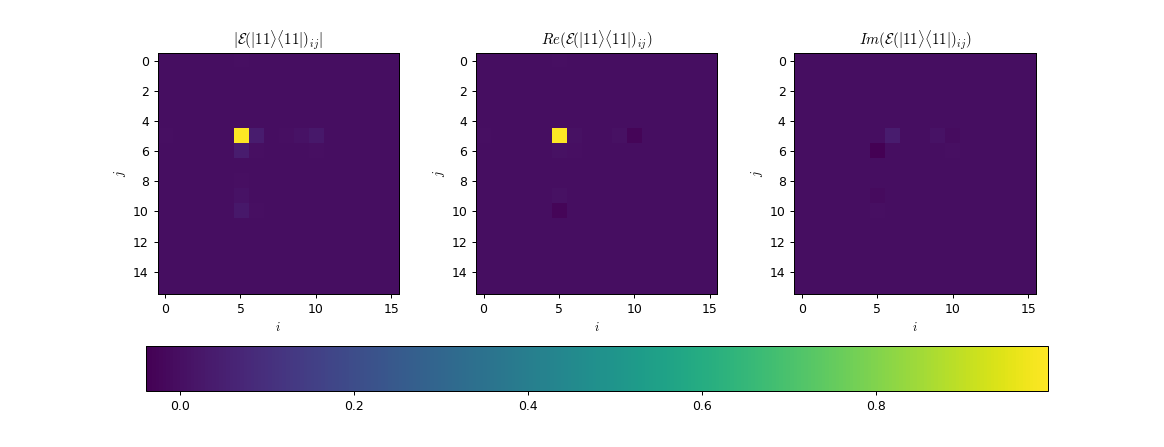

In [11]:
#a small test to spot bugs
pysqkit.tomography.tomoEnv.draw_mat(env_syst.gate(env_syst._dm_label((1,1))).full(), "\\mathcal{E} (| 11 \\rangle \\langle11 | )")

<IPython.core.display.Javascript object>


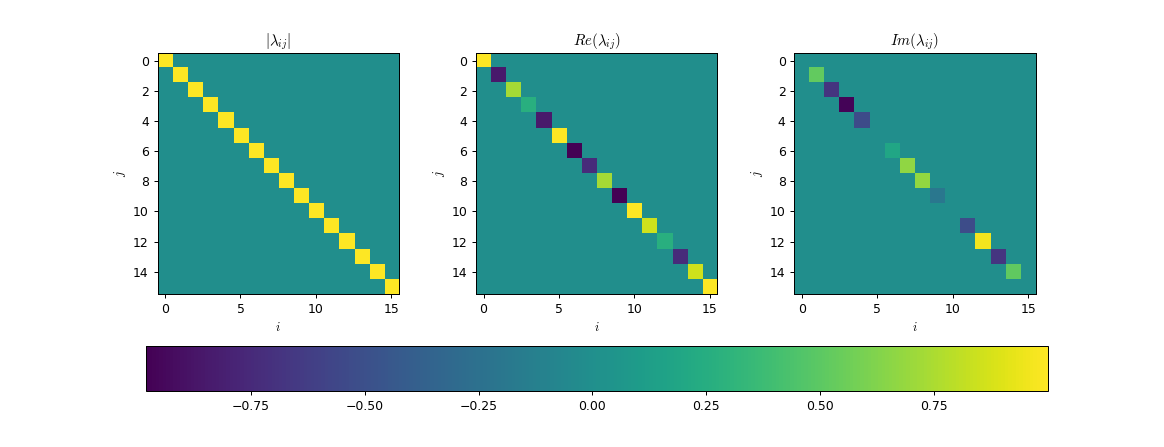

It took 76.27508473396301 seconds


In [12]:
deb =  time.time()
lambda_mat = env_syst.fct_to_lambda(in_labels = "comp_states", out_labels = "comp_states", draw_lambda = True, as_qobj = False)
print("It took" , time.time() - deb, "seconds")

#options for labels are "all" ; "comp_states" or a list

In [13]:
d1 = 4
d2 = env_syst.d - 4

L1 = env_syst.L1()
L2 = env_syst.L2()

In [14]:
print("L1 error is ; ", L1)
print("L2 error is ; ", L2)

print("d1 x L1 = ", d1*L1, "and d2 x L2 = ", d2*L2 )

L1 error is ;  (0.0006435068377883546-3.4137132428154653e-16j)
L2 error is ;  (0.00030363208244753325+3.2460737758508145e-17j)
d1 x L1 =  (0.0025740273511534184-1.3654852971261861e-15j) and d2 x L2 =  (0.003643584989370399+3.8952885310209774e-16j)


### Alternate L1 and L2

<IPython.core.display.Javascript object>


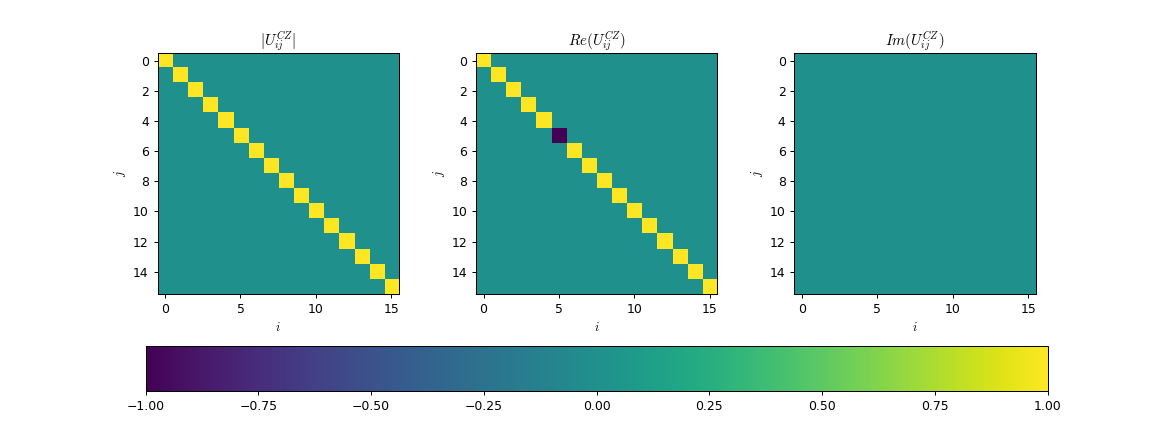

In [15]:
# We aim here for a CZ
U_ideal = np.diag(np.ones(env_syst.d))

U_ideal[env_syst.nb_levels[1]+1, env_syst.nb_levels[1]+1] = -1

pysqkit.tomography.tomoEnv.draw_mat(U_ideal, "U^{CZ}")

<IPython.core.display.Javascript object>


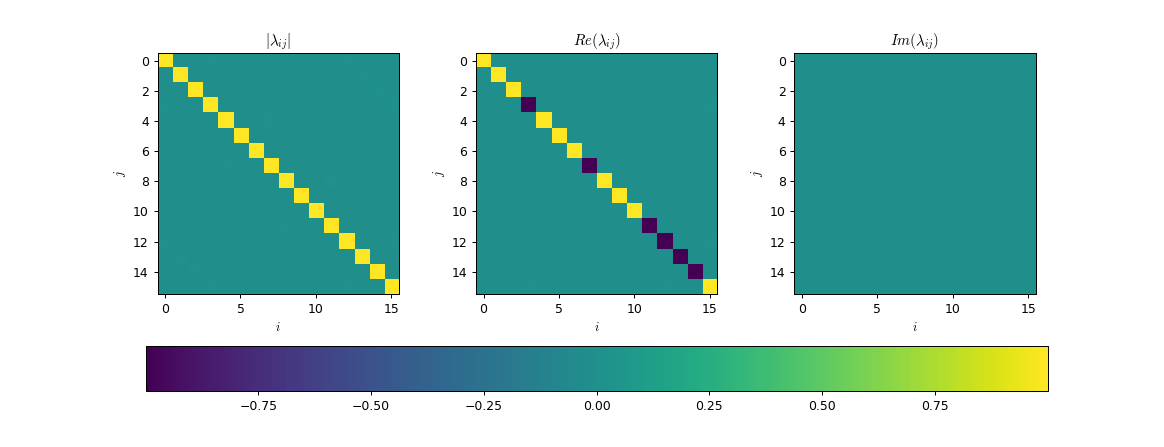

In [16]:
env_U_ideal = pysqkit.tomography.TomoEnv(system = None,
                                   definition_type = "U",
                                   nb_levels = env_syst.nb_levels, 
                                   param_syst = { 'U' : U_ideal}, 
                                   table_states = env_syst._table_states)

lambda_U_ideal = env_U_ideal.fct_to_lambda(draw_lambda = True)

In [18]:
def correc_U(env):
    
    #we bypass the gate implemented functions and give a ket to the system
    u_10_10 = (env.param_syst['simu'](env._ket_label((1,0))).dag() * env._ket_label((1,0)) ).full()
    u_01_01 = (env.param_syst['simu'](env._ket_label((0,1))).dag() * env._ket_label((0,1)) ).full()
    u_00_00 = (env.param_syst['simu'](env._ket_label((0,0))).dag() * env._ket_label((0,0)) ).full()
    
    phi_10 = cmath.phase(np.conj(u_00_00) * u_10_10) #u_00_00 a 1 in 00 (similar calculations)
    phi_01 = cmath.phase(np.conj(u_00_00) * u_01_01)
    
    p_phi10 = np.diag(np.ones(env.nb_levels[0])) + 0j
    p_phi01 = np.diag(np.ones(env.nb_levels[1])) + 0j
    p_phi10[:2, :2] = np.array([[1, 0], [0, np.exp(-1j*phi_10)]])
    p_phi01[:2, :2] = np.array([[1, 0], [0, np.exp(-1j*phi_01)]])
    
#     print(p_phi10, phi_01)
    return tensor_prod([p_phi10, p_phi01])

In [19]:
# pysqkit.tomography.tomoEnv.draw_mat(correc_U(env_syst), "correc")

<IPython.core.display.Javascript object>


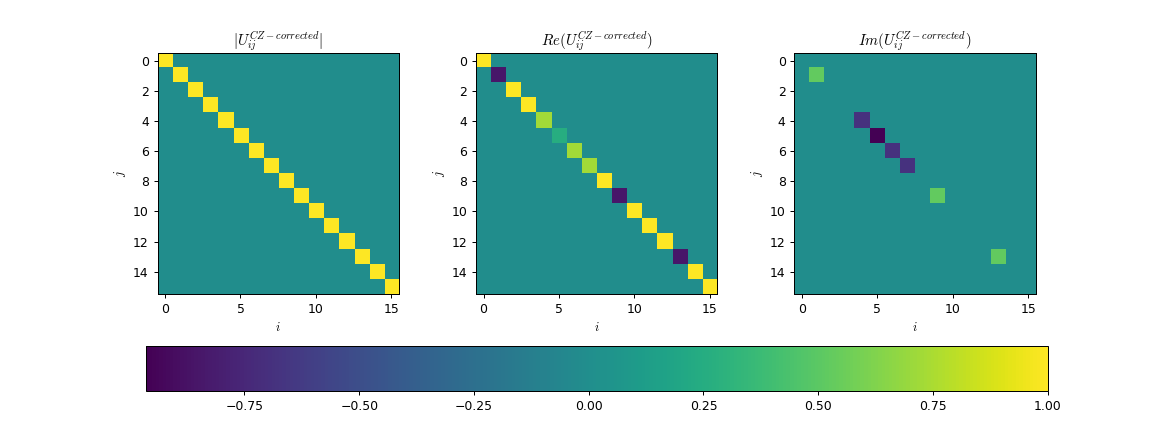

In [20]:
U_correction = correc_U(env_syst)
U_ideal_corrected = U_correction.conj().T.dot(U_ideal)

pysqkit.tomography.tomoEnv.draw_mat(U_ideal_corrected, "U^{CZ - corrected}")

<IPython.core.display.Javascript object>


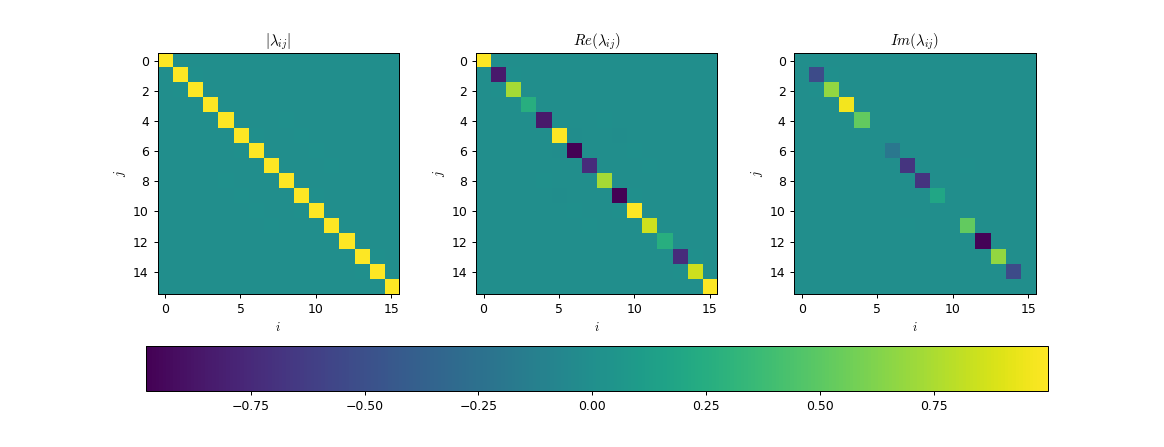

In [21]:
env_U_ideal_corrected = pysqkit.tomography.TomoEnv(system = None,
                                                   definition_type = "U",
                                                    nb_levels = env_syst.nb_levels, 
                                                   param_syst = { 'U' : U_ideal_corrected}, 
                                                   table_states = env_syst._table_states)

lambda_U_ideal_corrected = env_U_ideal_corrected.fct_to_lambda(draw_lambda = True)

In [22]:
deb = time.time()
alt_L1 = env_syst.L1_with_lambda()
print("done in ", time.time() - deb)

deb = time.time()
alt_L2 = env_syst.L2_with_lambda()
print("done in ", time.time() - deb)

deb = time.time()
alt_L1_corrected = env_syst.L1_with_lambda(U_ideal, correc_U)
print("done in ", time.time() - deb)

deb = time.time()
alt_L2_corrected = env_syst.L2_with_lambda(U_ideal, correc_U)
print("done in ", time.time() - deb)

done in  61.17355537414551
done in  753.0647075176239
done in  78.42799854278564
done in  803.9489178657532


In [23]:
print("alt L1 error is ; ", alt_L1)
print("alt L2 error is ; ", alt_L2)

print("d1 x L1 = ", d1*alt_L1, "and d2 x L2 = ", d2*alt_L2 )

alt L1 error is ;  (0.000767516276541369+2.723751317188348e-16j)
alt L2 error is ;  (0.0001958228632271199-9.330847672809336e-17j)
d1 x L1 =  (0.003070065106165476+1.0895005268753393e-15j) and d2 x L2 =  (0.0023498743587254387-1.1197017207371204e-15j)


In [24]:
print("alt L1_corrected error is ; ", alt_L1_corrected)
print("alt L2_corrected error is ; ", alt_L2_corrected)

print("d1 x L1_corrected = ", d1*alt_L1_corrected, "and d2 x L2_corrected = ", d2*alt_L2_corrected )

alt L1_corrected error is ;  (0.0008430056467048086-4.50337731285669e-11j)
alt L2_corrected error is ;  (0.00019581958449878408-1.773006438271061e-10j)
d1 x L1_corrected =  (0.0033720225868192344-1.801350925142676e-10j) and d2 x L2_corrected =  (0.002349835013985409-2.127607725925273e-09j)


In [25]:
print("L1 error is ; ", L1)
print("L2 error is ; ", L2)

print("d1 x L1 = ", d1*L1, "and d2 x L2 = ", d2*L2 )

L1 error is ;  (0.0006435068377883546-3.4137132428154653e-16j)
L2 error is ;  (0.00030363208244753325+3.2460737758508145e-17j)
d1 x L1 =  (0.0025740273511534184-1.3654852971261861e-15j) and d2 x L2 =  (0.003643584989370399+3.8952885310209774e-16j)


In [26]:
%notify

<IPython.core.display.Javascript object>

### Process fidelity

In [ ]:
# We aim here for a CZ
U_ideal = np.diag(np.ones(env_syst.d))

U_ideal[env_syst.nb_levels[1]+1, env_syst.nb_levels[1]+1] = -1

pysqkit.tomography.tomoEnv.draw_mat(U_ideal, "U^{CZ}")

In [ ]:
def correc_U(env):
    
    #we bypass the gate implemented functions and give a ket to the system
    u_10_10 = (env.param_syst['simu'](env._ket_label((1,0))).dag() * env._ket_label((1,0)) ).full()
    u_01_01 = (env.param_syst['simu'](env._ket_label((0,1))).dag() * env._ket_label((0,1)) ).full()
    u_00_00 = (env.param_syst['simu'](env._ket_label((0,0))).dag() * env._ket_label((0,0)) ).full()
    
    phi_10 = cmath.phase(np.conj(u_00_00) * u_10_10) #u_00_00 a 1 in 00 (similar calculations)
    phi_01 = cmath.phase(np.conj(u_00_00) * u_01_01)
    
    p_phi10 = np.diag(np.ones(env.nb_levels[0])) + 0j
    p_phi01 = np.diag(np.ones(env.nb_levels[1])) + 0j
    p_phi10[:2, :2] = np.array([[1, 0], [0, np.exp(1j*phi_10)]])
    p_phi01[:2, :2] = np.array([[1, 0], [0, np.exp(1j*phi_01)]])
    
#     print(p_phi10, phi_01)
    return tensor_prod([p_phi10, p_phi01])

In [ ]:
U_correction = correc_U(env_syst)
U_ideal_corrected = U_correction.conj().T.dot(U_ideal)

pysqkit.tomography.tomoEnv.draw_mat(U_ideal_corrected, "U^{CZ - corrected}")

In [ ]:
env_U_ideal_corrected = pysqkit.tomography.TomoEnv(system = None,
                                                   definition_type = "U",
                                                    nb_levels = env_syst.nb_levels, 
                                                   param_syst = { 'U' : U_ideal_corrected}, 
                                                   table_states = env_syst._table_states)

lambda_U_ideal_corrected = env_U_ideal_corrected.fct_to_lambda(draw_lambda = True)

In [ ]:
lambda_tilde = lambda_U_ideal_corrected.T.conj().dot(lambda_mat)
pysqkit.tomography.tomoEnv.draw_mat(lambda_tilde, "\\tilde{\lambda}")

#Should be close to identity

In [ ]:
from pysqkit.tomography.tomoEnv import *
F_pro = pysqkit.tomography.tomoEnv.process_fidelity(env_syst, U_ideal, correc_U)
print("The process fidelity (to match the corrected CZ) is F_pro =", F_pro)

In [ ]:
F = pysqkit.tomography.tomoEnv.avg_gate_fid(env_syst, U_ideal, correc_U)
print("The average gate fidelty (to match the corrected CZ) is F =", F)

In [ ]:
#Or all from scratch : 
L1_from_scratch = pysqkit.tomography.tomoEnv.L1_from_scratch(system)
F_pro_from_scratch = pysqkit.tomography.tomoEnv.process_fidelity_from_scratch(system, U_ideal, correc_U)
F_from_scratch = pysqkit.tomography.tomoEnv.avg_gate_fid_from_scratch(system, U_ideal, correc_U)

print("The L1 is :", L1_from_scratch)
print("The Fpro is :", F_pro_from_scratch)
print("The F is :", F_from_scratch)

# Old

In [ ]:
deb =  time.time()
chi_mat = env_simu.lambda_to_chi(lambda_mat, draw_chi = True )
print("It took" , time.time() - deb, "seconds")

In [ ]:
lambda_mat_2lev = np.zeros((16, 16))*1j

for i in range(16):
    for j in range(16):
        ani, bni, ami, bmi = tomo._n_th([2, 2, 2, 2], i) #i is |ani bni><ami bmi|
        anj, bnj, amj, bmj = tomo._n_th([2, 2, 2, 2], j)
        
        lambda_mat_2lev[i,j] = lambda_mat[ani*27 + bni * 9 + ami * 3 + bmi][anj*27 + bnj * 9 + amj* 3 + bmj]

In [ ]:
tomo.draw_mat(lambda_mat_2lev, "\lambda^2")

In [ ]:
chi_mat_2lev = tomo.lambda_to_chi(lambda_mat_2lev, [2,2], draw_chi = True)

chi_CZ = np.zeros((16,16))
chi_CZ[0,0] = 1
chi_CZ[0,3] = 1
chi_CZ[3,0] = 1
chi_CZ[3,3] = 1

chi_CZ[0,12] = 1
chi_CZ[3,12] = 1
chi_CZ[0,15] = -1
chi_CZ[3,15] = -1

chi_CZ[12,12] = 1
chi_CZ[15,12] = -1
chi_CZ[12,15] = -1
chi_CZ[15,15] = 1

chi_CZ[12,0] = 1
chi_CZ[12,3] = 1
chi_CZ[15,0] = -1
chi_CZ[15,3] = -1

tomo.draw_mat(chi_CZ, "\chi^{CZ}")